In [1]:
import time
import pickle
import numpy as np
import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm 
import json
from dateutil.parser import parse

In [2]:
from rdbtools import RdbParser, RdbCallback
from rdbtools.encodehelpers import bytes_to_unicode

class PublishCallback(RdbCallback):

    def __init__(self, is_unicode=False, start_ts=float('-inf'), stop_ts=float('+inf')):
        super(PublishCallback, self).__init__(string_escape=None)
        self.ranges = {}
        self.start = start_ts
        self.stop = stop_ts
        self.is_unicode = is_unicode

    def encode_key(self, key):
        return bytes_to_unicode(key, self._escape, skip_printable=True)

    def encode_value(self, val):
        if self.is_unicode:
            return bytes_to_unicode(val, self._escape)
        return val

    def start_sorted_set(self, key, length, expiry, info):
        self.ranges[self.encode_key(key)] = []

    def zadd(self, key, score, member):
        if self.start <= score <= self.stop:
            self.ranges[self.encode_key(key)].append((self.encode_value(member), round(score)))

    def end_sorted_set(self, key):
        encoded_key = self.encode_key(key)
        self.ranges[encoded_key] = list(reversed(self.ranges[encoded_key]))


def parse_dump_file(dump_file, start_ts=float("-inf"), stop_ts=float("+inf")):
    """Parse a redis dump file (rdb) and return the data within.

    Only supports SortedSet.

    Args:
        dump_file (str): Rdb path
        start_ts (float): timestamp of the first value to publish
        stop_ts (float): timestamp of the last value to publish

    Returns:
        ranges (dict): {
                'keyA': [(FrameDataDump1A, Score1A), ..., (FrameDataDumpNA, ScoreNA)],
                'keyB': [(FrameDataDump1B, Score1B), ..., (FrameDataDumpNB, ScoreNB)],
                ...
            }
    """
    t0 = time.time()

    callback = PublishCallback(start_ts=start_ts, stop_ts=stop_ts)
    rdb_parser = RdbParser(callback)
    rdb_parser.parse(dump_file)
    print("Parsed {} in {:.2f} s.".format(dump_file, time.time() - t0))
    print("Contains keys:", callback.ranges.keys())
    for k in callback.ranges.keys():
        print(
            "[{}] start_ts: {} | stop_ts: {}".format(
                k, callback.ranges[k][0][1], callback.ranges[k][-1][1]
            )
        )
    return callback.ranges

In [3]:
from ipywidgets import interact
import ipywidgets as widgets

In [5]:
tracks = parse_dump_file('../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.2.kickoff.rdb')
config = json.load(open('../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.json', 'r'))

Parsed ../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.2.kickoff.rdb in 1.77 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526825255814 | stop_ts: 1526825853694
[left] start_ts: 1526825255686 | stop_ts: 1526825853606


In [6]:
fd, ts = tracks['left'][0]


fd = pickle.loads(fd)
pprint.pprint(fd.__dict__.keys())

dict_keys(['ts', 'features', 'last', 'phase_state', 'stream_ts', 'top_view_player_positions', 'bboxes', 'valid_frame', 'packed_rects', 'top_view_ball_positions', 'mapping', 'player_detections', 'ball_detections', 'embeddings'])


In [7]:
kickoff_1 = config['phase_events'][2]['ts']
kickoff_time = int(parse(kickoff_1).timestamp()*1000)

In [8]:
config['phase_events'] 

[{'kickoff_team_id': 10,
  'phase': 1,
  'ts': '2018-05-20T13:10:06.054Z',
  'type': 'start_phase'},
 {'phase': 1, 'ts': '2018-05-20T13:55:08.940Z', 'type': 'end_phase'},
 {'kickoff_team_id': 2,
  'phase': 2,
  'ts': '2018-05-20T14:12:33.841Z',
  'type': 'start_phase'},
 {'phase': 2, 'ts': '2018-05-20T15:02:18.183Z', 'type': 'end_phase'}]

In [9]:
pitch_size=config['pitch_size']
print(pitch_size)

[105, 68]


In [10]:
detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}

timestamps = set()

def ball_ok(ball_pos, ball_det):
    if ball_pos[0] < 0 or ball_pos[1] < 0:
        return False
    if ball_det.confidence < 0.7:
        return False
    return True

for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
    fd_left = pickle.loads(fd_left)
    fd_right = pickle.loads(fd_right)
    if np.abs(ts_left - ts_right) < 100:
        ts_left = ts_right
    timestamps.update({ts_left, ts_right})

    detections['players']['left'][ts_left] = fd_left.top_view_player_positions
    detections['players']['right'][ts_right] = fd_right.top_view_player_positions
    detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
    detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
    

14948it [00:06, 2389.61it/s]


In [32]:
print(detections['players']['left'][1527429925546])

[[29.095022 29.967958]
 [ 6.593591 35.962074]
 [50.788593 58.98473 ]
 [46.238567 43.10845 ]
 [44.79777  61.75658 ]
 [45.57697  21.598154]
 [53.309696 59.887386]
 [51.673023 43.919613]
 [42.70895  37.20008 ]
 [31.43411  47.894142]
 [47.44661  43.588467]
 [51.327118 23.980663]
 [51.53116  33.31464 ]
 [36.823467 15.930965]]


1526825553841 1526825553846


<IPython.core.display.Javascript object>


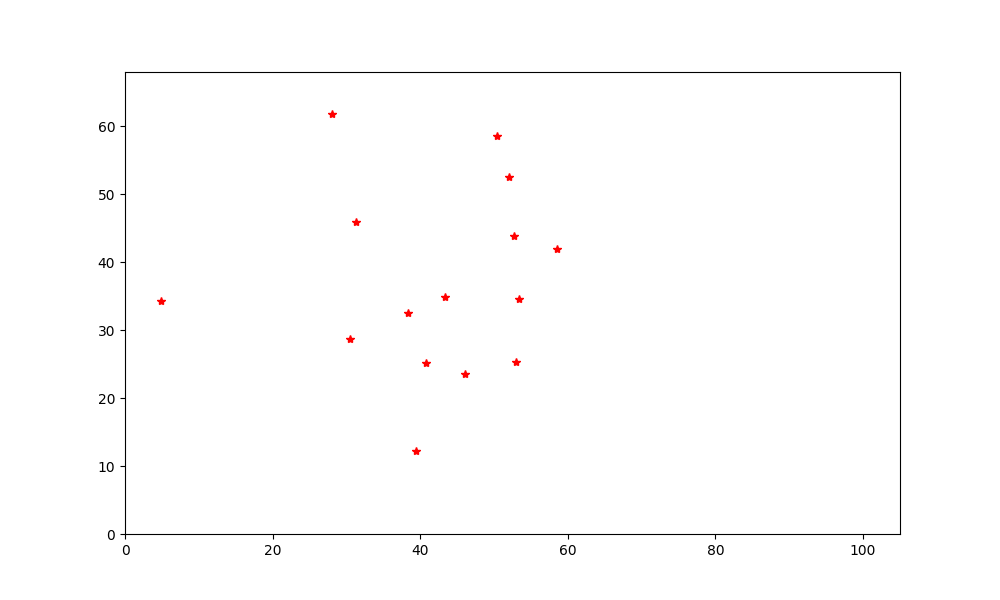

interactive(children=(SelectionSlider(description='ts', index=14512, options=(1526825255686, 1526825255726, 15…

In [11]:
timestamps_list = sorted(list(timestamps))
kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
kickoff_time_matched = timestamps_list[kickoff_time_ind]
print(kickoff_time, kickoff_time_matched)

%matplotlib notebook

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
left, = plt.plot([], '*r')
right, = plt.plot([], '*r')

left_b, = plt.plot([], 'ob')
right_b, = plt.plot([], 'ob')

plt.xlim([0, 105])
plt.ylim([0, 68])

def update(ts=kickoff_time_matched):
    if ts in detections['players']['left']:
        left.set_ydata(detections['players']['left'][ts][:, 1])
        left.set_xdata(detections['players']['left'][ts][:, 0])
    else:
        left.set_ydata([])
        left.set_xdata([])
        
    if ts in detections['players']['right']:
        right.set_ydata(detections['players']['right'][ts][:, 1])
        right.set_xdata(detections['players']['right'][ts][:, 0])
    else:
        right.set_ydata([])
        right.set_xdata([])

    if ts in detections['ball']['left'] and len(detections['ball']['left'][ts]):
        left_b.set_ydata(detections['ball']['left'][ts][:, 1])
        left_b.set_xdata(detections['ball']['left'][ts][:, 0])
    else:
        left_b.set_ydata([])
        left_b.set_xdata([])        
    if ts in detections['ball']['right'] and len(detections['ball']['right'][ts]):
        right_b.set_ydata(detections['ball']['right'][ts][:, 1])
        right_b.set_xdata(detections['ball']['right'][ts][:, 0])
    else:
        right_b.set_ydata([])
        right_b.set_xdata([])
    
    
wid = widgets.SelectionSlider(
    options=timestamps_list,
    value=kickoff_time_matched,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)
    
interact(update, ts = wid);

In [82]:
# {'id': 'd1a98e08-0f21-46fe-8457-01ff183ddbeb', 'calibration': {'views': ['left', 'right'], 'reference_landmarks': {'object': 'calibrations/tele2_landmarks.json', 'bucket': 'signality.ironfist.models'}}, 'replay_urls': ['//liveplay.signality.com/data/d1a98e08-0f21-46fe-8457-01ff183ddbeb_phase1.data', '//liveplay.signality.com/data/d1a98e08-0f21-46fe-8457-01ff183ddbeb_phase2.data'], 'camera_mode': 'static', 'away_team': {'colors': {'team': '#000000', 'goalkeeper': '#ffff00'}, 'logo_url': 'http://images.signality.com/team-logos/orebro.png', 'name': 'Örebro SK'}, 'phase_events': [{'type': 'start_phase', 'ts': datetime.datetime(2018, 5, 17, 17, 0, 2, 362000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e4e0>), 'kickoff_team_id': 12, 'phase': 1}, {'type': 'end_phase', 'ts': datetime.datetime(2018, 5, 17, 17, 47, 7, 92000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e518>), 'phase': 1}, {'type': 'start_phase', 'ts': datetime.datetime(2018, 5, 17, 18, 4, 2, 891000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e630>), 'kickoff_team_id': 11, 'phase': 2}, {'type': 'end_phase', 'ts': datetime.datetime(2018, 5, 17, 18, 52, 6, 565000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e6a0>), 'phase': 2}], 'start_time': datetime.datetime(2018, 5, 17, 19, 0, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e780>), 'state': 'Destroyed', 'external_data': {'smc': {'match_id': 3704, 'home_team_id': 11, 'league_id': 12, 'away_team_id': 12}}, 'streams': {'left': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/ca074983-09a2-451f-8730-90efa6701dc8/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e9e8>)}, 'autofollow_render_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/d890161e-59fa-4f39-9758-b9d5b10357af/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61e9b0>)}, 'virtual_panorama_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/b5e093f3-f8e7-4643-a87a-d9a76256a735/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 197000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ec88>)}, 'goal_south_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/c841f705-de34-4428-b56e-7c9803ab4eca/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 143000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61eac8>)}, 'right': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/d8112841-7cf8-48ae-89ce-f327c282916c/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 124000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ea20>)}, 'goal_north_segments': {'url': 'https://d35u71x3nb8v2y.cloudfront.net/f75295bb-c143-4472-a151-d849f9916e75/9a7b8e83-dbc0-436b-a116-7f8d085057c2/playlist.m3u8', 'utc': datetime.datetime(2018, 5, 17, 16, 45, 41, 141000, tzinfo=<rethinkdb.ast.RqlTzinfo object at 0x7f4d1c61ea58>)}}, 'pitch_size': [105, 68], 'home_team': {'colors': {'team': '#5a9dde', 'goalkeeper': '#ffffff'}, 'logo_url': 'http://images.signality.com/team-logos/djurgarden.png', 'name': 'Djurgårdens IF'}, 'referees': {'colors': '#000000'}, 'competition': 'Allsvenskan', 'redis': {'host': 'redis', 'port': 6379}, 'rethinkdb': {'host': 'db.signality.com', 'user': 'game_viewer', 'db': 'livetrack', 'ssl': {'ca_certs': '/home/ubuntu/workspace/ironfist/ironfist/utils/../applications/livetrack/config/db.signality.cert.pem'}, 'password': 'MmPHrqmXaVeu', 'port': 28015}, 'nchan': {'url': 'http://nchan:8080'}, 'arena': 'Tele2 Arena', 'stats': [{'home_team': {'failed_passes': 163, 'possessing_team': 0, 'passes': 181, 'distance': 62777.64480394193, 'possession': 25067, 'packing': 260}, 'source': 'signality', 'phase': 1, 'away_team': {'failed_passes': 163, 'possessing_team': 1, 'passes': 191, 'distance': 60097.76136929008, 'possession': 23934, 'packing': 252}, 'utc_time': 1526579225125, 'match_time': 2822763}, {'home_team': {'failed_passes': 157, 'possessing_team': 0, 'passes': 147, 'distance': 62576.815733754884, 'possession': 20009, 'packing': 196}, 'source': 'signality', 'phase': 2, 'away_team': {'failed_passes': 158, 'possessing_team': 1, 'passes': 206, 'distance': 57684.92804763888, 'possession': 28384, 'packing': 240}, 'utc_time': 1526583124565, 'match_time': 2881674}], 'video_shape': [2160, 3840, 3], 'rdb': [{'key': '20180517.djurgårdens-if-örebro-sk.2.rdb', 'bucket': 'signality.soccer.backup', 'phase': 2}]}

In [12]:
def select_time(time_list,detections):
    l=list()
    truth_list=list()
    for i in range(len(time_list)):
        truth_list.append(True)
        if time_list[i] in detections['players']['left'] and time_list[i] in detections['players']['right']:
            l.append([time_list[i],time_list[i]])
            truth_list[i]=False
        if i>0:
            if time_list[i-1] in detections['players']['left'] and time_list[i] in detections['players']['right'] and truth_list[i] and truth_list[i-1] and time_list[i]-time_list[i-1]<=20:
                l.append([time_list[i-1],time_list[i]])
                truth_list[i]=False
            if time_list[i] in detections['players']['left'] and time_list[i-1] in detections['players']['right'] and truth_list[i] and truth_list[i-1] and time_list[i]-time_list[i-1]<=20:
                l.append([time_list[i],time_list[i-1]])
                truth_list[i]=False
    return l

l=select_time(timestamps_list,detections)

In [102]:
def players_grid(pitch_size,players):
    compteur=0
    grid=[0 for i in range(32)]
    length=pitch_size[0]
    width=pitch_size[1]
    length_edge=length/8
    width_edge=width/4
    for i in range(len(players)):
        k=0
        j=0
        if players[i][0]<=length and players[i][1]<=width and players[i][0]>=0 and players[i][1]>=0 :
            compteur+=1
            while players[i][0]>(k+1)*length_edge:
                k+=1
            while players[i][1]>(j+1)*width_edge:
                j+=1
            grid[8*j+k]+=1
    if compteur>0:
        new_grid=[float(grid[i])/float(compteur) for i in range(32)]
    else:
        new_grid=grid
    return new_grid

def ball_grid(pitch_size,ball):
    grid=[0 for i in range(35)]
    length=pitch_size[0]
    width=pitch_size[1]
    length_edge=length/7
    width_edge=width/5
    for i in range(len(ball)):
        k=0
        j=0
        if ball[i][0]<=length and ball[i][1]<=width and ball[i][0]>=0 and ball[i][1]>=0:
            while ball[i][0]>(k+1)*length_edge:
                k+=1
            while ball[i][1]>(j+1)*width_edge:
                j+=1
            grid[7*j+k]+=1
    return grid

In [60]:
def pitch_composition_t(time,detections,pitch_size):
    compo=list()
    if isinstance(detections['ball']['left'][time[0]],list):
        compo=compo+ball_grid(pitch_size,detections['ball']['left'][time[0]])
    if isinstance(detections['ball']['left'][time[0]],np.ndarray):
        compo=compo+ball_grid(pitch_size,detections['ball']['left'][time[0]].tolist())
        
    if isinstance(detections['ball']['right'][time[1]],list):
        compo=compo+ball_grid(pitch_size,detections['ball']['right'][time[1]])
    if isinstance(detections['ball']['right'][time[1]],np.ndarray):
        compo=compo+ball_grid(pitch_size,detections['ball']['right'][time[1]].tolist())
    
    if isinstance(detections['players']['left'][time[0]],list):
        compo=compo+players_grid(pitch_size,detections['players']['left'][time[0]])
    if isinstance(detections['players']['left'][time[0]],np.ndarray):
        compo=compo+players_grid(pitch_size,detections['players']['left'][time[0]].tolist())
        
    if isinstance(detections['players']['right'][time[1]],list):
        compo=compo+players_grid(pitch_size,detections['players']['right'][time[1]])
    if isinstance(detections['players']['right'][time[1]],np.ndarray):
        compo=compo+players_grid(pitch_size,detections['players']['right'][time[1]].tolist())
    return compo
    
def pitch_composition(time_list,detections,pitch_size):
    l=select_time(time_list,detections)
    seq=list()
    for i in range(len(l)):
        seq.append(pitch_composition_t(l[i],detections,pitch_size))
    return seq


In [109]:
def movement_sequences(inputs,outputs,regression_output=[]):
    inputs=np.array(inputs)
    new_inputs=list()
    new_outputs=list()
    new_regression_output=list()
    for i in range(len(outputs)-2):
        new_inputs.append(inputs[i+1].tolist()+(inputs[i+2]-inputs[i]).tolist()+(inputs[i+1]-inputs[i]).tolist())
        new_outputs.append(outputs[i+1])
        if len(regression_output)>0:
            new_regression_output.append(regression_output[i+1])
    if len(regression_output)>0:
        return new_inputs,new_outputs,new_regression_output
    return new_inputs,new_outputs

def sequence_composition(time_list,detections,pitch_size,size_sequence,diminish_size):
    sequences=list()
    pitch_compo=pitch_composition(time_list,detections,pitch_size)
    for i in range(0,len(pitch_compo)-size_sequence+1,diminish_size):
        seq_t=list()
        for j in range(0,size_sequence,diminish_size):
            seq_t=seq_t+pitch_compo[i+j]
        sequences.append(seq_t)
    return sequences



In [62]:
def labels_seq_regression(time_list,detections,pitch_size,diminish_size,kickoff_time):
    l=select_time(time_list,detections)
    y=list()
    for i in range(0,len(l)-diminish_size+1):
        if l[i][0]<=kickoff_time and kickoff_time<=l[i+diminish_size-1][0]:
            y.append(1)
        else:
            y.append(0)
    return y

def labels_regression(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time):
    label_seq=labels_seq_regression(time_list,detections,pitch_size,diminish_size,kickoff_time)
    sequences=list()
    for i in range(0,len(label_seq)-size_sequence+1,diminish_size):
        seq_t=list()
        for j in range(0,size_sequence,diminish_size):
            seq_t.append(label_seq[i+j])
        sequences.append(seq_t)
    return sequences

def select_kickoff_sequences(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time):
    X=sequence_composition(time_list,detections,pitch_size,size_sequence,diminish_size)
    Y=labels(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time)
    y=labels_regression(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time)
    X,Y,y=movement_sequences(X,Y,y)
    new_X=list()
    new_y=list()
    if Y.count(1)>0:
        print(len(y),len(X))
        print(Y.index(1))
        print(Y.count(1))
        new_y=y[Y.index(1):Y.index(1)+Y.count(1)]
        new_X=X[Y.index(1):Y.index(1)+Y.count(1)]
    return new_X,new_y
    
def detect_kickofftime(outputs):
    new_outputs=list()
    for i in range(len(outputs)):
        new_outputs.append(len(outputs[i])-1-outputs[i].index(1))
    return new_outputs



In [63]:
def labels(time_list,detections,pitch_size,size_sequence,diminish_size,kickoff_time):
    l=select_time(time_list,detections)
    y=list()
    for i in range(0,len(l)-size_sequence+1,diminish_size):
        if max(l[i][0],l[i][1])+1500<=kickoff_time and kickoff_time+2000<=min(l[i+size_sequence-1][0],l[i+size_sequence-1][1]):
            y.append(1)
        else:
            y.append(-1)
    return y

def reduce_size(X,Y,reduc_size):
    compteur=0
    new_X=list()
    new_Y=list()
    for i in range(len(X)):
        if Y[i]==1:
            new_Y.append(1)
            new_X.append(X[i])
            compteur=0
        if Y[i]==-1:
            compteur+=1
        if compteur>=reduc_size:
            compteur=0
            new_Y.append(Y[i])
            new_X.append(X[i])
    return new_X,new_Y
X=sequence_composition(timestamps_list,detections,pitch_size,500,25)
Y=labels(timestamps_list,detections,pitch_size,500,25,kickoff_time_matched)
print(Y.count(1))
#X,Y=movement_sequences(X,Y)
#X,Y=reduce_size(X,Y,10)
Y.index(1)


17


280

In [64]:
import pickle
import glob

In [110]:
import datetime 

wrong_kickofftimes=dict()
wrong_kickofftimes['../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1']=1523192632495
wrong_kickofftimes['../kickoff-data-corrected/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.1']=1522596661071
wrong_kickofftimes['../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.2']=1522591362762
wrong_kickofftimes['../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.2']=1527429926306
wrong_kickofftimes['../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.2']=1523196154797
wrong_kickofftimes['../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1']=1523192430151
wrong_kickofftimes['../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.2']=1524074584895
wrong_kickofftimes['../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.1']=0
wrong_kickofftimes['../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.2']=0
wrong_kickofftimes['../kickoff-data-corrected/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1']=0
wrong_kickofftimes['../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.2']=0
wrong_kickofftimes['../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.2']=0
wrong_kickofftimes['../kickoff-data-corrected/58bc418b-cf05-415e-9dd1-6f4808535976.2']=0
wrong_kickofftimes['../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.2']=0
wrong_kickofftimes['../kickoff-data-corrected/84e8b33c-d912-495e-9e21-84bdd18e0e04.1']=0
wrong_kickofftimes['../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.1']=0
wrong_kickofftimes['../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.1']=0
wrong_kickofftimes['../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.1']=0
wrong_kickofftimes['../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1']=0
wrong_kickofftimes['../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.2']=1523383385046

def correct_kickoff_time(name_file,right_kickoff_time,phase):
    jsonFile = open(name_file, "r") # Open the JSON file for reading
    config = json.load(jsonFile) # Read the JSON into the buffer
    k=[i for i in range(4) if config['phase_events'][i]['type'] == 'start_phase' and config['phase_events'][i]['phase'] == int(phase)][0]
    jsonFile.close() # Close the JSON file

    ## Working with buffered content
    tmp = config["phase_events"][k]["ts"]
    config["phase_events"][k]["ts"]=datetime.datetime.fromtimestamp(right_kickoff_time/1000).isoformat()
    print("Json file edited")

    ## Save our changes to JSON file
    jsonFile = open(name_file, "w+")
    jsonFile.write(json.dumps(config))
    jsonFile.close()
    
def correct_json_files(name_file_rdb):
    if name_file_rdb in wrong_kickofftimes.keys():
        name_file_json=('..{}.json'.format(name_file_rdb.split('.')[-2]))
        phase=name_file_rdb.split('.')[-1]
        correct_kickoff_time(name_file_json,wrong_kickofftimes[name_file_rdb],phase)

In [111]:
def create_dataset(file_name,reduc_size,problem="classification"):
    compteur=0
    path_to_rdbs = '../kickoff-data-corrected/*.rdb'
    for rdb_file in glob.glob(path_to_rdbs):
        #Edit json file
        game_half = rdb_file.rstrip('.kickoff.rdb')
        phase = game_half.split('.')[-1]
        correct_json_files(game_half)
        
        #Import correct data
        tracks = parse_dump_file('{}.kickoff.rdb'.format(game_half))
        config = json.load(open('..{}.json'.format(game_half.split('.')[-2]), 'r'))
        print('..{}.json'.format(game_half.split('.')[-2]))
        print(config['phase_events'])
        kickoff_1 = [p_e['ts'] for p_e in config['phase_events'] if p_e['type'] == 'start_phase' and p_e['phase'] == int(phase)][0]
        kickoff_time = int(parse(kickoff_1).timestamp()*1000)
        print(kickoff_time)
        pitch_size=config['pitch_size']
        detections = {'ball':{'left':{}, 'right':{}}, 'players':{'left':{}, 'right':{}}}
        timestamps = set()
        for (fd_left, ts_left), (fd_right, ts_right) in tqdm(zip(tracks['left'], tracks['right'])):
            fd_left = pickle.loads(fd_left)
            fd_right = pickle.loads(fd_right)
            if np.abs(ts_left - ts_right) < 100:
                ts_left = ts_right
            timestamps.update({ts_left, ts_right})
            detections['players']['left'][ts_left] = fd_left.top_view_player_positions
            detections['players']['right'][ts_right] = fd_right.top_view_player_positions
            detections['ball']['left'][ts_left] = np.array([bp for bp, bd in zip(fd_left.top_view_ball_positions, fd_left.ball_detections) if ball_ok(bp, bd)])
            detections['ball']['right'][ts_right] = np.array([bp for bp, bd in zip(fd_right.top_view_ball_positions, fd_right.ball_detections) if ball_ok(bp, bd)])
        timestamps_list = sorted(list(timestamps))
        kickoff_time_ind = np.argmin(np.abs(np.subtract(timestamps_list, kickoff_time)))
        kickoff_time_matched = timestamps_list[kickoff_time_ind]
        
        #Create inputs
        
        #Classification
        if problem=="classification":
            X=sequence_composition(timestamps_list,detections,pitch_size,500,25)
            Y=labels(timestamps_list,detections,pitch_size,500,25,kickoff_time_matched)
            print(len(X[0]))
            X,Y=movement_sequences(X,Y)
            print(Y.count(1))
            X,Y=reduce_size(X,Y,reduc_size)
            print(len(X[0]),len(Y))
            print(Y.count(1))
            
            #Create file
            add_data=True
            if Y.count(1)>0 and compteur==0:
                with open(file_name, 'wb') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([X,Y], f)
                    compteur+=1
                    add_data=False
            if Y.count(1)>0 and add_data:
                with open(file_name, 'ab') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([X,Y], f)
                    compteur+=1
                    print(compteur)
         
        #Regression
        if problem=="regression":
            X,y=select_kickoff_sequences(timestamps_list,detections,pitch_size,500,25,kickoff_time_matched)
            print(len(X),len(y))
            print(y)
            y=detect_kickofftime(y)
            print(y)
        #Create file
            add_data=True
            if len(y)>0 and compteur==0:
                with open(file_name, 'wb') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([X,y], f)
                    compteur+=1
                    add_data=False
            if len(y)>0 and add_data:
                with open(file_name, 'ab') as f:
                    # Pickle the 'data' dictionary using the highest protocol available.
                    pickle.dump([X,y], f)
                    compteur+=1
                    print(compteur)
                    

In [112]:
create_dataset('../kickoff-data-corrected/data.pickle.1.10.mov.classif',10)

Json file edited


504it [00:00, 2464.85it/s]

Parsed ../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.1.kickoff.rdb in 1.75 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526316922561 | stop_ts: 1526317521441
[left] start_ts: 1526316922655 | stop_ts: 1526317521455
../kickoff-data-corrected/41c3f1b3-a868-459b-9766-760be49947b2.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-05-14T17:46:22.241Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-05-14T18:01:26.755Z', 'kickoff_team_id': 1, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-05-14T18:49:29.553Z', 'type': 'end_phase'}]
0


14972it [00:07, 1926.31it/s]


2680
0
8040 57
0


488it [00:00, 2422.63it/s]

Parsed ../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.1.kickoff.rdb in 1.79 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522673702216 | stop_ts: 1522674302096
[left] start_ts: 1522673702294 | stop_ts: 1522674302134
../kickoff-data-corrected/f9f01fbf-6871-4303-b43f-29c2dd16909d.json
[{'phase': 1, 'ts': '2018-04-02T13:00:02.978Z', 'kickoff_team_id': 15, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-02T13:47:02.983Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 4, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-02T14:50:07.639Z', 'type': 'end_phase'}]
1522674002978


14996it [00:07, 1878.77it/s]


2680
17
8040 72
17


347it [00:00, 3460.75it/s]

Parsed ../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.2.kickoff.rdb in 1.45 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523642362979 | stop_ts: 1523642961819
[left] start_ts: 1523642363613 | stop_ts: 1523642962133
../kickoff-data-corrected/6e26f66b-a921-4919-9d7d-1bd59f935e78.json
[{'phase': 1, 'ts': '2018-04-13T17:01:26.037Z', 'kickoff_team_id': 3, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-13T17:48:25.115Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-13T18:04:22.102Z', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-13T18:52:23.632Z', 'type': 'end_phase'}]
1523642662102


14964it [00:06, 2299.55it/s]


2680
16
8040 72
16
2


174it [00:00, 1733.18it/s]

Parsed ../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.2.kickoff.rdb in 1.75 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523800613851 | stop_ts: 1523801213411
[left] start_ts: 1523800614341 | stop_ts: 1523801213661
../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'phase': 1, 'ts': '2018-04-15T13:00:57.169Z', 'kickoff_team_id': 4, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-15T13:46:01.064Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-15T14:01:53.073Z', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-15T14:50:42.654Z', 'type': 'end_phase'}]
1523800913073


14983it [00:07, 2107.09it/s]


2680
16
8040 72
16
3


548it [00:00, 5474.20it/s]

Parsed ../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.1.kickoff.rdb in 1.44 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523706912088 | stop_ts: 1523707510928
[left] start_ts: 1523706904558 | stop_ts: 1523707503158
../kickoff-data-corrected/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'phase': 1, 'ts': '2018-04-14T12:00:03.074Z', 'kickoff_team_id': 1, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-14T12:45:30.997Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 7, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-14T13:50:58.493Z', 'type': 'end_phase'}]
1523707203074


14966it [00:05, 2672.69it/s]


2680
17
8040 72
17
4
Json file edited


293it [00:00, 2929.51it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1.kickoff.rdb in 1.70 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523192129071 | stop_ts: 1523192727911
[left] start_ts: 1523192129517 | stop_ts: 1523192728157
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'phase': 1, 'ts': '2018-04-08T13:00:30.151000', 'kickoff_team_id': 7, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T13:47:27.898Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T14:02:34.797000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T14:51:34.402Z', 'type': 'end_phase'}]
1523192430151


14966it [00:08, 1792.29it/s]


2680
16
8040 71
16
5
Json file edited


408it [00:00, 4073.72it/s]

Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1.kickoff.rdb in 1.58 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523201094061 | stop_ts: 1523201692981
[left] start_ts: 1523201092829 | stop_ts: 1523201692349
../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T16:17:54.242Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T16:34:19.995Z', 'kickoff_team_id': 16, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T17:23:20.816Z', 'type': 'end_phase'}]
0


14951it [00:07, 1898.87it/s]


2680
0
8040 57
0


273it [00:00, 2722.95it/s]

Parsed ../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.1.kickoff.rdb in 1.72 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526225101172 | stop_ts: 1526225700052
[left] start_ts: 1526225101102 | stop_ts: 1526225700022
../kickoff-data-corrected/050a1fae-5d48-4048-8f66-a3f12eca843d.json
[{'phase': 1, 'ts': '2018-05-13T15:30:00.666Z', 'kickoff_team_id': 14, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-05-13T16:16:59.553Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-05-13T16:32:02.287Z', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-05-13T17:20:33.812Z', 'type': 'end_phase'}]
1526225400666


14972it [00:07, 1998.47it/s]


2680
16
8040 72
16
6
Json file edited


212it [00:00, 2117.77it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.2.kickoff.rdb in 1.69 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524074286793 | stop_ts: 1524074883313
[left] start_ts: 1524074286135 | stop_ts: 1524074882975
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'phase': 1, 'ts': '2018-04-18T17:00:28.694Z', 'kickoff_team_id': 11, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-18T17:46:35.647Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-18T18:03:04.895000', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-18T18:52:04.739Z', 'type': 'end_phase'}]
1524074584895


14914it [00:07, 2069.39it/s]


2680
17
8040 71
17
7


624it [00:00, 3110.93it/s]

Parsed ../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.1.kickoff.rdb in 1.71 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523714121038 | stop_ts: 1523714720678
[left] start_ts: 1523714121022 | stop_ts: 1523714720662
../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'phase': 1, 'ts': '2018-04-14T14:00:20.059Z', 'kickoff_team_id': 16, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-14T14:46:37.899Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-14T15:02:36.879Z', 'kickoff_team_id': 5, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-14T15:51:35.702Z', 'type': 'end_phase'}]
1523714420059


14991it [00:08, 1857.10it/s]


2680
17
8040 73
17
8


115it [00:00, 1144.55it/s]

Parsed ../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.1.kickoff.rdb in 1.93 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524070530793 | stop_ts: 1524071128313
[left] start_ts: 1524070530135 | stop_ts: 1524071127975
../kickoff-data-corrected/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'phase': 1, 'ts': '2018-04-18T17:00:28.694Z', 'kickoff_team_id': 11, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-18T17:46:35.647Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-18T18:03:04.895000', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-18T18:52:04.739Z', 'type': 'end_phase'}]
1524070828694


14939it [00:09, 1649.77it/s]


2680
17
8040 71
17
9


241it [00:00, 2401.20it/s]

Parsed ../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.2.kickoff.rdb in 1.65 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523204962061 | stop_ts: 1523205559981
[left] start_ts: 1523204960829 | stop_ts: 1523205559349
../kickoff-data-corrected/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T16:17:54.242Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T16:34:19.995Z', 'kickoff_team_id': 16, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T17:23:20.816Z', 'type': 'end_phase'}]
1523205259995


14949it [00:07, 1871.49it/s]


2680
17
8040 71
17
10


383it [00:00, 1870.00it/s]

Parsed ../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1.kickoff.rdb in 2.00 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524070510889 | stop_ts: 1524071110729
[left] start_ts: 1524070510939 | stop_ts: 1524071110739
../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'phase': 1, 'ts': '2018-04-18T17:00:10.108Z', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-18T17:47:10.874Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-18T18:02:18.645Z', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-18T18:49:19.022Z', 'type': 'end_phase'}]
1524070810108


14996it [00:09, 1558.76it/s]


2680
16
8040 72
16
11


252it [00:00, 1293.79it/s]

Parsed ../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.1.kickoff.rdb in 1.79 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522587361602 | stop_ts: 1522587961442
[left] start_ts: 1522587361524 | stop_ts: 1522587961404
../kickoff-data-corrected/314f4989-398c-45a3-a74f-9f1adac71bf1.json
[{'phase': 1, 'ts': '2018-04-01T13:01:01.209Z', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-01T13:47:08.486Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 5, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-01T14:50:51.103Z', 'type': 'end_phase'}]
1522587661209


14908it [00:07, 1927.17it/s]


2680
16
8040 71
16
12


444it [00:00, 4435.06it/s]

Parsed ../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.2.kickoff.rdb in 1.61 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526825255814 | stop_ts: 1526825853694
[left] start_ts: 1526825255686 | stop_ts: 1526825853606
../kickoff-data-corrected/03d0ac1b-8adb-457d-9519-b6c879a92df3.json
[{'phase': 1, 'ts': '2018-05-20T13:10:06.054Z', 'kickoff_team_id': 10, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-05-20T13:55:08.940Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-05-20T14:12:33.841Z', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-05-20T15:02:18.183Z', 'type': 'end_phase'}]
1526825553841


14948it [00:06, 2188.90it/s]


2680
17
8040 71
17
13


359it [00:00, 3587.30it/s]

Parsed ../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.2.kickoff.rdb in 1.35 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523296748330 | stop_ts: 1523297346370
[left] start_ts: 1523296760048 | stop_ts: 1523297356248
../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'phase': 1, 'ts': '2018-04-09T17:00:44.667Z', 'kickoff_team_id': 15, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-09T17:47:46.113Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-09T18:04:16.558Z', 'kickoff_team_id': 5, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-09T18:53:12.188Z', 'type': 'end_phase'}]
1523297056558


14906it [00:05, 2537.24it/s]


2680
17
8040 70
17
14
Json file edited


387it [00:00, 1892.81it/s]

Parsed ../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.2.kickoff.rdb in 1.62 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523383083286 | stop_ts: 1523383682846
[left] start_ts: 1523383083898 | stop_ts: 1523383683138
../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-10T17:47:16.674Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-10T18:03:05.046000', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-10T18:51:05.058Z', 'type': 'end_phase'}]
1523383385046


14982it [00:07, 2081.96it/s]


2680
16
8040 71
16
15


297it [00:00, 1504.46it/s]

Parsed ../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.1.kickoff.rdb in 2.28 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523805900650 | stop_ts: 1523806499170
[left] start_ts: 1523805900082 | stop_ts: 1523806498882
../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.json
[{'phase': 1, 'ts': '2018-04-15T15:29:58.007Z', 'kickoff_team_id': 6, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-15T16:16:00.459Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-15T16:31:33.353Z', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-15T17:19:35.565Z', 'type': 'end_phase'}]
1523806198007


14963it [00:10, 1473.26it/s]


2680
16
8040 71
16
16
Json file edited


250it [00:00, 1229.54it/s]

Parsed ../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1.kickoff.rdb in 2.03 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523192332775 | stop_ts: 1523192929695
[left] start_ts: 1523192332019 | stop_ts: 1523192929339
../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'phase': 1, 'ts': '2018-04-08T13:03:52.495000', 'kickoff_team_id': 11, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T13:48:52.077Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T14:05:14.493Z', 'kickoff_team_id': 14, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T14:53:40.200Z', 'type': 'end_phase'}]
1523192632495


14925it [00:08, 1668.94it/s]


2680
16
8040 71
16
17


363it [00:00, 3624.25it/s]

Parsed ../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.2.kickoff.rdb in 1.69 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523809596650 | stop_ts: 1523810194170
[left] start_ts: 1523809596082 | stop_ts: 1523810193882
../kickoff-data-corrected/3382a9d0-02ff-4f23-9748-1b715d85b731.json
[{'phase': 1, 'ts': '2018-04-15T15:29:58.007Z', 'kickoff_team_id': 6, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-15T16:16:00.459Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-15T16:31:33.353Z', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-15T17:19:35.565Z', 'type': 'end_phase'}]
1523809893353


14938it [00:06, 2253.31it/s]


2680
16
8040 71
16
18


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.2.kickoff.rdb in 1.54 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522686513973 | stop_ts: 1522687111853
[left] start_ts: 1522686514029 | stop_ts: 1522687111869
../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'phase': 1, 'ts': '2018-04-02T15:32:25.029Z', 'kickoff_team_id': 7, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-02T16:17:34.362Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-02T16:33:31.520Z', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-02T17:22:39.373Z', 'type': 'end_phase'}]
1522686811520


14946it [00:06, 2293.44it/s]


2680
16
8040 71
16
19
Json file edited


635it [00:00, 3038.52it/s]

Parsed ../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.2.kickoff.rdb in 1.73 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523195853031 | stop_ts: 1523196452911
[left] start_ts: 1523195853517 | stop_ts: 1523196453157
../kickoff-data-corrected/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'phase': 1, 'ts': '2018-04-08T13:00:30.151000', 'kickoff_team_id': 7, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T13:47:27.898Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T14:02:34.797000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T14:51:34.402Z', 'type': 'end_phase'}]
1523196154797


14992it [00:08, 1845.51it/s]


2680
16
8040 71
16
20


0it [00:00, ?it/s]

Parsed ../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.2.kickoff.rdb in 1.42 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522591235411 | stop_ts: 1522591831931
[left] start_ts: 1522591235535 | stop_ts: 1522591832015
../kickoff-data-corrected/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 1, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-01T13:47:53.692Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-01T14:05:32.177Z', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-01T14:53:51.954Z', 'type': 'end_phase'}]
1522591532177


14913it [00:06, 2314.47it/s]


2680
16
8040 71
16
21


509it [00:00, 2490.61it/s]

Parsed ../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.2.kickoff.rdb in 1.50 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523800767317 | stop_ts: 1523801366837
[left] start_ts: 1523800767685 | stop_ts: 1523801367045
../kickoff-data-corrected/cd6d495b-8fe4-4586-8861-ba579cf3a6e9.json
[{'phase': 1, 'ts': '2018-04-15T13:01:26.995Z', 'kickoff_team_id': None, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-15T13:48:30.166Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-15T14:04:27.679Z', 'kickoff_team_id': None, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-15T14:54:33.364Z', 'type': 'end_phase'}]
1523801067679


14984it [00:06, 2201.93it/s]


2680
17
8040 72
17
22


153it [00:00, 1525.33it/s]

Parsed ../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.1.kickoff.rdb in 2.25 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527425706526 | stop_ts: 1527426305406
[left] start_ts: 1527425706666 | stop_ts: 1527426305466
../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json
[{'phase': 1, 'ts': '2018-05-27T13:00:05.658Z', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-05-27T13:48:06.407Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-05-27T14:05:26.306000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-05-27T14:54:05.123Z', 'type': 'end_phase'}]
1527426005658


14971it [00:10, 1377.12it/s]


2680
17
8040 72
17
23


360it [00:00, 1793.45it/s]

Parsed ../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.2.kickoff.rdb in 1.81 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524074238929 | stop_ts: 1524074838729
[left] start_ts: 1524074238899 | stop_ts: 1524074838739
../kickoff-data-corrected/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'phase': 1, 'ts': '2018-04-18T17:00:10.108Z', 'kickoff_team_id': 13, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-18T17:47:10.874Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-18T18:02:18.645Z', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-18T18:49:19.022Z', 'type': 'end_phase'}]
1524074538645


14996it [00:09, 1643.93it/s]


2680
17
8040 73
17
24


203it [00:00, 994.73it/s]

Parsed ../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.1.kickoff.rdb in 1.95 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523109442628 | stop_ts: 1523110041148
[left] start_ts: 1523109442596 | stop_ts: 1523110041116
../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.json
[{'phase': 1, 'ts': '2018-04-07T14:02:21.372Z', 'kickoff_team_id': 12, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-07T14:47:22.773Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-07T15:02:55.779Z', 'kickoff_team_id': 4, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-07T15:50:52.908Z', 'type': 'end_phase'}]
1523109741372


14963it [00:09, 1650.08it/s]


2680
17
8040 73
17
25


472it [00:00, 2359.71it/s]

Parsed ../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.2.kickoff.rdb in 1.51 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523717857078 | stop_ts: 1523718456678
[left] start_ts: 1523717857062 | stop_ts: 1523718456662
../kickoff-data-corrected/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'phase': 1, 'ts': '2018-04-14T14:00:20.059Z', 'kickoff_team_id': 16, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-14T14:46:37.899Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-14T15:02:36.879Z', 'kickoff_team_id': 5, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-14T15:51:35.702Z', 'type': 'end_phase'}]
1523718156879


14991it [00:06, 2223.24it/s]


2680
17
8040 73
17
26


462it [00:00, 2295.62it/s]

Parsed ../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.1.kickoff.rdb in 1.82 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523796957851 | stop_ts: 1523797557411
[left] start_ts: 1523796958381 | stop_ts: 1523797557661
../kickoff-data-corrected/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'phase': 1, 'ts': '2018-04-15T13:00:57.169Z', 'kickoff_team_id': 4, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-15T13:46:01.064Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-15T14:01:53.073Z', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-15T14:50:42.654Z', 'type': 'end_phase'}]
1523797257169


14984it [00:08, 1826.19it/s]


2680
17
8040 73
17
27
Json file edited


327it [00:00, 1625.27it/s]

Parsed ../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.2.kickoff.rdb in 1.85 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527429626566 | stop_ts: 1527430225406
[left] start_ts: 1527429626666 | stop_ts: 1527430225466
../kickoff-data-corrected/2739587b-312a-4d40-ba1a-9b5e3ebf5c9c.json
[{'phase': 1, 'ts': '2018-05-27T13:00:05.658Z', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-05-27T13:48:06.407Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-05-27T14:05:26.306000', 'kickoff_team_id': 9, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-05-27T14:54:05.123Z', 'type': 'end_phase'}]
1527429926306


14971it [00:08, 1726.71it/s]


2680
16
8040 72
16
28


295it [00:00, 2949.55it/s]

Parsed ../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.2.kickoff.rdb in 1.35 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523901471657 | stop_ts: 1523902070297
[left] start_ts: 1523901471243 | stop_ts: 1523902070043
../kickoff-data-corrected/a185c6c8-7383-4d19-927f-dc8f70726c34.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 15, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-16T17:46:39.313Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-16T18:02:50.296Z', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-16T18:49:49.424Z', 'type': 'end_phase'}]
1523901770296


14967it [00:06, 2472.65it/s]


2680
16
8040 72
16
29


579it [00:00, 2829.70it/s]

Parsed ../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.1.kickoff.rdb in 1.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522682845973 | stop_ts: 1522683445853
[left] start_ts: 1522682846069 | stop_ts: 1522683445869
../kickoff-data-corrected/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'phase': 1, 'ts': '2018-04-02T15:32:25.029Z', 'kickoff_team_id': 7, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-02T16:17:34.362Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-02T16:33:31.520Z', 'kickoff_team_id': 8, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-02T17:22:39.373Z', 'type': 'end_phase'}]
1522683145029


14997it [00:05, 2574.47it/s]


2680
17
8040 73
17
30
Json file edited


91it [00:00, 903.06it/s]

Parsed ../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.1.kickoff.rdb in 1.40 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523379375326 | stop_ts: 1523379973846
[left] start_ts: 1523379375938 | stop_ts: 1523379974138
../kickoff-data-corrected/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'phase': 1, 'ts': '1970-01-01T00:00:00', 'kickoff_team_id': 6, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-10T17:47:16.674Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-10T18:03:05.046000', 'kickoff_team_id': 2, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-10T18:51:05.058Z', 'type': 'end_phase'}]
0


14955it [00:06, 2297.59it/s]


2680
0
8040 57
0


278it [00:00, 2776.19it/s]

Parsed ../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.2.kickoff.rdb in 1.57 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523196016735 | stop_ts: 1523196614695
[left] start_ts: 1523196016019 | stop_ts: 1523196614339
../kickoff-data-corrected/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'phase': 1, 'ts': '2018-04-08T13:03:52.495000', 'kickoff_team_id': 11, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-08T13:48:52.077Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-08T14:05:14.493Z', 'kickoff_team_id': 14, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-08T14:53:40.200Z', 'type': 'end_phase'}]
1523196314493


14949it [00:07, 1998.23it/s]


2680
16
8040 71
16
31


426it [00:00, 2112.72it/s]

Parsed ../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.2.kickoff.rdb in 1.72 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523113078628 | stop_ts: 1523113675148
[left] start_ts: 1523113078596 | stop_ts: 1523113675116
../kickoff-data-corrected/76d4b783-ae63-4c60-815f-6a81beef6451.json
[{'phase': 1, 'ts': '2018-04-07T14:02:21.372Z', 'kickoff_team_id': 12, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-07T14:47:22.773Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-07T15:02:55.779Z', 'kickoff_team_id': 4, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-07T15:50:52.908Z', 'type': 'end_phase'}]
1523113375779


14913it [00:07, 1963.95it/s]


2680
16
8040 71
16
32


849it [00:00, 4306.96it/s]

Parsed ../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.1.kickoff.rdb in 1.37 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523292936370 | stop_ts: 1523293534370
[left] start_ts: 1523292948088 | stop_ts: 1523293544248
../kickoff-data-corrected/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'phase': 1, 'ts': '2018-04-09T17:00:44.667Z', 'kickoff_team_id': 15, 'type': 'start_phase'}, {'phase': 1, 'ts': '2018-04-09T17:47:46.113Z', 'type': 'end_phase'}, {'phase': 2, 'ts': '2018-04-09T18:04:16.558Z', 'kickoff_team_id': 5, 'type': 'start_phase'}, {'phase': 2, 'ts': '2018-04-09T18:53:12.188Z', 'type': 'end_phase'}]
1523293244667


14861it [00:05, 2492.23it/s]


2680
16
8040 69
16
33


In [64]:
create_dataset('../kickoff-data-corrected/data.pickle.1.10.acc.regression',10,"regression")

846it [00:00, 4234.27it/s]

Parsed ../kickoff-detection-data/24978380-482e-4ba4-a124-5142d43f8c91.2.kickoff.rdb in 0.57 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527184564976 | stop_ts: 1527184864816
[left] start_ts: 1527184568814 | stop_ts: 1527184864734
../kickoff-detection-data/24978380-482e-4ba4-a124-5142d43f8c91.json
[{'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-24T17:00:00.628Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-24T17:45:58.124Z'}, {'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-24T18:01:04.269Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-24T18:49:34.388Z'}]
1527184864269


7398it [00:02, 3455.41it/s]


0 0
[]
[]


385it [00:00, 3849.49it/s]

Parsed ../kickoff-detection-data/e0646790-9750-47eb-85ac-a7065fbcd4dd.2.kickoff.rdb in 0.65 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524414577904 | stop_ts: 1524414874304
[left] start_ts: 1524414578448 | stop_ts: 1524414874608
../kickoff-detection-data/e0646790-9750-47eb-85ac-a7065fbcd4dd.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-22T15:29:51.323Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-22T16:18:51.239Z'}, {'kickoff_team_id': 10, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-22T16:34:34.675Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-22T17:22:35.491Z'}]
1524414874675


7405it [00:02, 3273.94it/s]


0 0
[]
[]


795it [00:00, 4119.98it/s]

Parsed ../kickoff-detection-data/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.1.kickoff.rdb in 1.82 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523984147529 | stop_ts: 1523984746449
[left] start_ts: 1523984148353 | stop_ts: 1523984746873
../kickoff-detection-data/bff5f37c-be85-4f08-b6d4-a01e6c22fe0e.json
[{'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-17T17:00:46.604Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-17T17:45:52.314Z'}, {'kickoff_team_id': 3, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-17T18:00:53.147Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-17T18:51:00.072Z'}]
1523984446604


14964it [00:07, 2031.95it/s]


576 576
280
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

524it [00:00, 2560.89it/s]

Parsed ../kickoff-detection-data/41c3f1b3-a868-459b-9766-760be49947b2.1.kickoff.rdb in 2.10 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526316922561 | stop_ts: 1526317521441
[left] start_ts: 1526316922655 | stop_ts: 1526317521455
../kickoff-detection-data/41c3f1b3-a868-459b-9766-760be49947b2.json
[{'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-14T17:00:21.871Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-14T17:46:22.241Z'}, {'kickoff_team_id': 1, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-14T18:01:26.755Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-14T18:49:29.553Z'}]
1526317221871


14972it [00:07, 1992.20it/s]


577 577
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

354it [00:00, 3535.79it/s]

Parsed ../kickoff-detection-data/aadecf3a-0d92-4ace-b643-ced44474e157.2.kickoff.rdb in 0.66 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524160591665 | stop_ts: 1524160889465
[left] start_ts: 1524160591139 | stop_ts: 1524160889179
../kickoff-detection-data/aadecf3a-0d92-4ace-b643-ced44474e157.json
[{'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-19T17:00:01.137Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-19T17:46:04.420Z'}, {'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-19T18:01:29.369Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-19T18:49:42.844Z'}]
1524160889369


7446it [00:02, 2892.80it/s]


0 0
[]
[]


485it [00:00, 2511.22it/s]

Parsed ../kickoff-detection-data/24978380-482e-4ba4-a124-5142d43f8c91.1.kickoff.rdb in 1.24 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527180900976 | stop_ts: 1527181200816
[left] start_ts: 1527180904814 | stop_ts: 1527181200734
../kickoff-detection-data/24978380-482e-4ba4-a124-5142d43f8c91.json
[{'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-24T17:00:00.628Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-24T17:45:58.124Z'}, {'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-24T18:01:04.269Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-24T18:49:34.388Z'}]
1527181200628


7399it [00:03, 1933.62it/s]


0 0
[]
[]


479it [00:00, 2401.33it/s]

Parsed ../kickoff-detection-data/f9f01fbf-6871-4303-b43f-29c2dd16909d.1.kickoff.rdb in 2.66 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522673702216 | stop_ts: 1522674302096
[left] start_ts: 1522673702294 | stop_ts: 1522674302134
../kickoff-detection-data/f9f01fbf-6871-4303-b43f-29c2dd16909d.json
[{'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-02T13:00:02.978Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-02T13:47:02.983Z'}, {'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-02T14:02:01.386Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-02T14:50:07.639Z'}]
1522674002978


14996it [00:08, 1865.15it/s]


577 577
281
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

223it [00:00, 1104.22it/s]

Parsed ../kickoff-detection-data/c0b1883d-4420-48aa-9805-9318a20e56ae.1.kickoff.rdb in 3.03 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527350105245 | stop_ts: 1527350403085
[left] start_ts: 1527350105211 | stop_ts: 1527350403091
../kickoff-detection-data/c0b1883d-4420-48aa-9805-9318a20e56ae.json
[{'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-26T16:00:03.259Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-26T16:46:00.357Z'}, {'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-26T17:01:25.967Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-26T17:49:27.835Z'}]
1527350403259


7447it [00:06, 1120.65it/s]


0 0
[]
[]


538it [00:00, 2661.33it/s]

Parsed ../kickoff-detection-data/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.1.kickoff.rdb in 0.79 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525620373530 | stop_ts: 1525620670290
[left] start_ts: 1525620373398 | stop_ts: 1525620670238
../kickoff-detection-data/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.json
[{'kickoff_team_id': 10, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-06T15:31:10.100Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-06T16:16:18.200Z'}, {'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-06T16:32:05.306Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-06T17:20:08.236Z'}]
1525620670100


7421it [00:02, 2933.87it/s]


0 0
[]
[]


742it [00:00, 3770.60it/s]

Parsed ../kickoff-detection-data/0ad7e9ee-4ff5-4bfa-b2f6-82a1cde04eeb.2.kickoff.rdb in 1.77 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524414345649 | stop_ts: 1524414944249
[left] start_ts: 1524414345139 | stop_ts: 1524414943979
../kickoff-detection-data/0ad7e9ee-4ff5-4bfa-b2f6-82a1cde04eeb.json
[{'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-22T15:30:02.243Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-22T16:15:07.030Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-22T16:30:44.239Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-22T17:20:43.958Z'}]
1524414644239


14966it [00:06, 2492.60it/s]


576 576
280
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

343it [00:00, 3421.69it/s]

Parsed ../kickoff-detection-data/6e26f66b-a921-4919-9d7d-1bd59f935e78.2.kickoff.rdb in 1.76 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523642362979 | stop_ts: 1523642961819
[left] start_ts: 1523642363613 | stop_ts: 1523642962133
../kickoff-detection-data/6e26f66b-a921-4919-9d7d-1bd59f935e78.json
[{'kickoff_team_id': 3, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-13T17:01:26.037Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-13T17:48:25.115Z'}, {'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-13T18:04:22.102Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-13T18:52:23.632Z'}]
1523642662102


14964it [00:06, 2305.12it/s]


576 576
280
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

170it [00:00, 1692.76it/s]

Parsed ../kickoff-detection-data/27bea627-3caa-47ee-93c3-67f0e26f3034.2.kickoff.rdb in 2.35 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523800613851 | stop_ts: 1523801213411
[left] start_ts: 1523800614341 | stop_ts: 1523801213661
../kickoff-detection-data/27bea627-3caa-47ee-93c3-67f0e26f3034.json
[{'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-15T13:00:57.169Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-15T13:46:01.064Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-15T14:01:53.073Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-15T14:50:42.654Z'}]
1523800913073


14983it [00:07, 2090.66it/s]


577 577
280
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

454it [00:00, 2280.06it/s]

Parsed ../kickoff-detection-data/e40014f3-5c63-4869-94af-75c4e0547de4.1.kickoff.rdb in 1.60 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527094503764 | stop_ts: 1527094802564
[left] start_ts: 1527094503678 | stop_ts: 1527094802558
../kickoff-detection-data/e40014f3-5c63-4869-94af-75c4e0547de4.json
[{'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-23T17:00:02.891Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-23T17:45:05.284Z'}, {'kickoff_team_id': 3, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-23T18:02:02.986Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-23T18:51:09.847Z'}]
1527094802891


7471it [00:04, 1695.83it/s]


0 0
[]
[]


411it [00:00, 2015.10it/s]

Parsed ../kickoff-detection-data/536b68b9-507f-408a-9a91-f994667b1d16.2.kickoff.rdb in 0.86 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526833546293 | stop_ts: 1526833843133
[left] start_ts: 1526833546311 | stop_ts: 1526833843111
../kickoff-detection-data/536b68b9-507f-408a-9a91-f994667b1d16.json
[{'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-20T15:30:13.835Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-20T16:15:14.598Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-20T16:30:43.121Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-20T17:19:46.634Z'}]
1526833843121


7421it [00:03, 2351.37it/s]


0 0
[]
[]


797it [00:00, 4142.58it/s]

Parsed ../kickoff-detection-data/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.1.kickoff.rdb in 1.65 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523706912088 | stop_ts: 1523707510928
[left] start_ts: 1523706904558 | stop_ts: 1523707503158
../kickoff-detection-data/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'kickoff_team_id': 1, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-14T12:00:03.074Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-14T12:45:30.997Z'}, {'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-14T13:00:50.467Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-14T13:50:58.493Z'}]
1523707203074


14966it [00:05, 2625.40it/s]


569 569
272
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

215it [00:00, 2148.72it/s]

Parsed ../kickoff-detection-data/75366863-8063-4ece-8aca-1dcf75d22448.1.kickoff.rdb in 0.28 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527181308926 | stop_ts: 1527181605806
[left] start_ts: 1527181308818 | stop_ts: 1527181605738
../kickoff-detection-data/75366863-8063-4ece-8aca-1dcf75d22448.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-24T17:06:45.366Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-24T17:52:47.009Z'}, {'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-24T18:12:56.972Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-24T19:02:55.588Z'}]
1527181605366


7423it [00:00, 8588.53it/s]


0 0
[]
[]


809it [00:00, 3957.24it/s]

Parsed ../kickoff-detection-data/456910d1-b523-4ff2-b60c-fcd1f016b96d.2.kickoff.rdb in 0.65 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524506250924 | stop_ts: 1524506550764
[left] start_ts: 1524506251416 | stop_ts: 1524506551016
../kickoff-detection-data/456910d1-b523-4ff2-b60c-fcd1f016b96d.json
[{'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-23T17:00:01.962Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-23T17:47:08.130Z'}, {'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-23T18:02:31.991Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-23T18:50:33.464Z'}]
1524506551991


7490it [00:02, 3313.72it/s]


0 0
[]
[]


525it [00:00, 2728.04it/s]

Parsed ../kickoff-detection-data/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.1.kickoff.rdb in 2.44 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523192129071 | stop_ts: 1523192727911
[left] start_ts: 1523192129517 | stop_ts: 1523192728157
../kickoff-detection-data/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-08T13:00:28.503Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-08T13:47:27.898Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-08T14:02:33.117Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-08T14:51:34.402Z'}]
1523192428503


14966it [00:08, 1814.51it/s]


576 576
280
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

291it [00:00, 2907.97it/s]

Parsed ../kickoff-detection-data/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.2.kickoff.rdb in 1.68 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523710560128 | stop_ts: 1523711157928
[left] start_ts: 1523710552598 | stop_ts: 1523711150158
../kickoff-detection-data/b0cbf7ed-a9ce-4434-9e4d-072065ee61bc.json
[{'kickoff_team_id': 1, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-14T12:00:03.074Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-14T12:45:30.997Z'}, {'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-14T13:00:50.467Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-14T13:50:58.493Z'}]
1523710850467


14941it [00:06, 2425.39it/s]


568 568
272
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

326it [00:00, 1649.84it/s]

Parsed ../kickoff-detection-data/d1a98e08-0f21-46fe-8457-01ff183ddbeb.1.kickoff.rdb in 1.86 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526576105219 | stop_ts: 1526576402099
[left] start_ts: 1526576105405 | stop_ts: 1526576402165
../kickoff-detection-data/d1a98e08-0f21-46fe-8457-01ff183ddbeb.json
[{'kickoff_team_id': 12, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-17T17:00:02.362Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-17T17:47:07.092Z'}, {'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-17T18:04:02.891Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-17T18:52:06.565Z'}]
1526576402362


7420it [00:05, 1419.00it/s]


0 0
[]
[]


716it [00:00, 3711.56it/s]

Parsed ../kickoff-detection-data/9acafc14-55f4-499e-90d9-4db2f121801b.2.kickoff.rdb in 0.72 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526229880495 | stop_ts: 1526230177335
[left] start_ts: 1526229880539 | stop_ts: 1526230177379
../kickoff-detection-data/9acafc14-55f4-499e-90d9-4db2f121801b.json
[{'kickoff_team_id': 12, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-13T15:45:34.522Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-13T16:33:39.123Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-13T16:49:37.864Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-13T17:39:37.349Z'}]
1526230177864


7422it [00:02, 2619.05it/s]


0 0
[]
[]


616it [00:00, 3052.14it/s]

Parsed ../kickoff-detection-data/3d29af74-d98c-415b-a1dc-6b034671d831.2.kickoff.rdb in 1.51 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527098333133 | stop_ts: 1527098931013
[left] start_ts: 1527098333205 | stop_ts: 1527098931045
../kickoff-detection-data/3d29af74-d98c-415b-a1dc-6b034671d831.json
[{'kickoff_team_id': 10, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-23T17:00:29.087Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-23T17:48:32.142Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-23T18:03:51.076Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-23T18:54:13.202Z'}]
1527098631076


14946it [00:06, 2361.85it/s]


576 576
279
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

808it [00:00, 4004.06it/s]

Parsed ../kickoff-detection-data/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.1.kickoff.rdb in 2.00 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523201094061 | stop_ts: 1523201692981
[left] start_ts: 1523201092829 | stop_ts: 1523201692349
../kickoff-detection-data/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json
[{'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-08T15:29:52.779Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-08T16:17:54.242Z'}, {'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-08T16:34:19.995Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-08T17:23:20.816Z'}]
1523201392779


14951it [00:07, 1944.53it/s]


573 573
280
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

502it [00:00, 5013.32it/s]

Parsed ../kickoff-detection-data/da82a1ce-2e4c-4337-8ba8-3f2525399e31.2.kickoff.rdb in 0.64 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525624022583 | stop_ts: 1525624319463
[left] start_ts: 1525624022661 | stop_ts: 1525624319501
../kickoff-detection-data/da82a1ce-2e4c-4337-8ba8-3f2525399e31.json
[{'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-06T15:30:55.282Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-06T16:16:55.775Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-06T16:31:59.785Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-06T17:19:59.649Z'}]
1525624319785


7421it [00:02, 3226.86it/s]


0 0
[]
[]


450it [00:00, 2223.44it/s]

Parsed ../kickoff-detection-data/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.2.kickoff.rdb in 0.93 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524322643076 | stop_ts: 1524322942636
[left] start_ts: 1524322642512 | stop_ts: 1524322942312
../kickoff-detection-data/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json
[{'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-21T14:00:32.294Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-21T14:45:33.074Z'}, {'kickoff_team_id': 12, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-21T15:02:22.137Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-21T15:50:24.649Z'}]
1524322942137


7489it [00:03, 2081.84it/s]


0 0
[]
[]


268it [00:00, 1381.24it/s]

Parsed ../kickoff-detection-data/70593a9a-5258-4f89-a402-b555c8ee3514.1.kickoff.rdb in 1.68 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525521349195 | stop_ts: 1525521646035
[left] start_ts: 1525521349217 | stop_ts: 1525521646057
../kickoff-detection-data/70593a9a-5258-4f89-a402-b555c8ee3514.json
[{'kickoff_team_id': 3, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-05T12:00:46.974Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-05T12:47:24.013Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-05T13:03:49.366Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-05T13:51:49.753Z'}]
1525521646974


7422it [00:04, 1587.08it/s]


0 0
[]
[]


449it [00:00, 2328.33it/s]

Parsed ../kickoff-detection-data/050a1fae-5d48-4048-8f66-a3f12eca843d.1.kickoff.rdb in 2.47 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526225101172 | stop_ts: 1526225700052
[left] start_ts: 1526225101102 | stop_ts: 1526225700022
../kickoff-detection-data/050a1fae-5d48-4048-8f66-a3f12eca843d.json
[{'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-13T15:30:00.666Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-13T16:16:59.553Z'}, {'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-13T16:32:02.287Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-13T17:20:33.812Z'}]
1526225400666


14972it [00:07, 2057.90it/s]


577 577
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

1065it [00:00, 5176.03it/s]

Parsed ../kickoff-detection-data/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.1.kickoff.rdb in 0.77 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525611300264 | stop_ts: 1525611597984
[left] start_ts: 1525611301214 | stop_ts: 1525611598494
../kickoff-detection-data/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.json
[{'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-06T12:59:58.803Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-06T13:45:00.746Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-06T14:00:42.453Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-06T14:48:47.422Z'}]
1525611598803


7433it [00:03, 2397.97it/s]


0 0
[]
[]


419it [00:00, 2090.57it/s]

Parsed ../kickoff-detection-data/57bf9b24-5c68-464f-9e74-20d0b2508bba.2.kickoff.rdb in 2.15 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524074286793 | stop_ts: 1524074883313
[left] start_ts: 1524074286135 | stop_ts: 1524074882975
../kickoff-detection-data/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-18T17:00:28.694Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-18T17:46:35.647Z'}, {'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-18T18:03:03.900Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-18T18:52:04.739Z'}]
1524074583900


14914it [00:07, 2033.97it/s]


574 574
278
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

631it [00:00, 3183.97it/s]

Parsed ../kickoff-detection-data/4be6ef54-2541-42d0-a334-e513a535029c.1.kickoff.rdb in 2.00 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523714121038 | stop_ts: 1523714720678
[left] start_ts: 1523714121022 | stop_ts: 1523714720662
../kickoff-detection-data/4be6ef54-2541-42d0-a334-e513a535029c.json
[{'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-14T14:00:20.059Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-14T14:46:37.899Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-14T15:02:36.879Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-14T15:51:35.702Z'}]
1523714420059


14991it [00:08, 1869.18it/s]


578 578
280
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

596it [00:00, 2851.71it/s]

Parsed ../kickoff-detection-data/c7acc25c-8411-4683-96ec-e26dee9cec34.2.kickoff.rdb in 0.65 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524405418777 | stop_ts: 1524405718137
[left] start_ts: 1524405418073 | stop_ts: 1524405717793
../kickoff-detection-data/c7acc25c-8411-4683-96ec-e26dee9cec34.json
[{'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-22T13:00:00.017Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-22T13:46:09.238Z'}, {'kickoff_team_id': 3, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-22T14:01:57.969Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-22T14:50:02.088Z'}]
1524405717969


7485it [00:02, 2718.19it/s]


0 0
[]
[]


655it [00:00, 3180.53it/s]

Parsed ../kickoff-detection-data/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.2.kickoff.rdb in 0.70 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525624025530 | stop_ts: 1525624325290
[left] start_ts: 1525624025358 | stop_ts: 1525624325238
../kickoff-detection-data/9ab7ccfb-75cb-4756-9eb5-fe8c29de8fcc.json
[{'kickoff_team_id': 10, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-06T15:31:10.100Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-06T16:16:18.200Z'}, {'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-06T16:32:05.306Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-06T17:20:08.236Z'}]
1525624325306


7495it [00:02, 2785.21it/s]


0 0
[]
[]


247it [00:00, 1233.01it/s]

Parsed ../kickoff-detection-data/6e26f66b-a921-4919-9d7d-1bd59f935e78.1.kickoff.rdb in 2.25 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523638586979 | stop_ts: 1523639185819
[left] start_ts: 1523638587613 | stop_ts: 1523639186133
../kickoff-detection-data/6e26f66b-a921-4919-9d7d-1bd59f935e78.json
[{'kickoff_team_id': 3, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-13T17:01:26.037Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-13T17:48:25.115Z'}, {'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-13T18:04:22.102Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-13T18:52:23.632Z'}]
1523638886037


14963it [00:08, 1863.63it/s]


576 576
280
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

253it [00:00, 1249.64it/s]

Parsed ../kickoff-detection-data/57bf9b24-5c68-464f-9e74-20d0b2508bba.1.kickoff.rdb in 2.89 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524070530793 | stop_ts: 1524071128313
[left] start_ts: 1524070530135 | stop_ts: 1524071127975
../kickoff-detection-data/57bf9b24-5c68-464f-9e74-20d0b2508bba.json
[{'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-18T17:00:28.694Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-18T17:46:35.647Z'}, {'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-18T18:03:03.900Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-18T18:52:04.739Z'}]
1524070828694


14939it [00:09, 1656.53it/s]


575 575
279
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

643it [00:00, 3335.54it/s]

Parsed ../kickoff-detection-data/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.1.kickoff.rdb in 0.93 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526921712730 | stop_ts: 1526922009650
[left] start_ts: 1526921712782 | stop_ts: 1526922009662
../kickoff-detection-data/66b6caf7-e5c0-45dd-874f-de8ac2e3c9ff.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-21T17:00:09.374Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-21T17:46:11.855Z'}, {'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-21T18:01:52.583Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-21T18:51:25.546Z'}]
1526922009374


7422it [00:02, 2910.53it/s]


0 0
[]
[]


247it [00:00, 2467.80it/s]

Parsed ../kickoff-detection-data/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.2.kickoff.rdb in 2.02 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523204962061 | stop_ts: 1523205559981
[left] start_ts: 1523204960829 | stop_ts: 1523205559349
../kickoff-detection-data/2b8bcfd6-5f57-46de-aacd-e932ac8e1697.json
[{'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-08T15:29:52.779Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-08T16:17:54.242Z'}, {'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-08T16:34:19.995Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-08T17:23:20.816Z'}]
1523205259995


14949it [00:07, 1883.51it/s]


575 575
279
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

812it [00:00, 3859.81it/s]

Parsed ../kickoff-detection-data/23fb8811-638e-4be8-a01d-76cad0f5a5bf.1.kickoff.rdb in 0.93 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526133303581 | stop_ts: 1526133602461
[left] start_ts: 1526133303595 | stop_ts: 1526133602435
../kickoff-detection-data/23fb8811-638e-4be8-a01d-76cad0f5a5bf.json
[{'kickoff_team_id': 3, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-12T14:00:02.187Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-12T14:46:02.666Z'}, {'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-12T15:01:23.069Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-12T15:48:40.504Z'}]
1526133602187


7472it [00:02, 2529.27it/s]


0 0
[]
[]


383it [00:00, 1873.74it/s]

Parsed ../kickoff-detection-data/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.1.kickoff.rdb in 2.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524070510889 | stop_ts: 1524071110729
[left] start_ts: 1524070510939 | stop_ts: 1524071110739
../kickoff-detection-data/b4dbea7c-c72f-4dd6-b57c-8fb7b8b38eb5.json
[{'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-18T17:00:10.108Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-18T17:47:10.874Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-18T18:02:18.645Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-18T18:49:19.022Z'}]
1524070810108


14996it [00:09, 1563.77it/s]


578 578
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

383it [00:00, 1898.47it/s]

Parsed ../kickoff-detection-data/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.1.kickoff.rdb in 1.84 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524156948802 | stop_ts: 1524157246362
[left] start_ts: 1524156948162 | stop_ts: 1524157246082
../kickoff-detection-data/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.json
[{'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-19T17:00:46.040Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-19T17:45:47.791Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-19T18:01:35.679Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-19T18:51:07.597Z'}]
1524157246040


7440it [00:05, 1448.18it/s]


0 0
[]
[]


278it [00:00, 1370.74it/s]

Parsed ../kickoff-detection-data/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.1.kickoff.rdb in 2.14 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525006796888 | stop_ts: 1525007393688
[left] start_ts: 1525006796874 | stop_ts: 1525007393674
../kickoff-detection-data/cf16ebf4-49fc-4991-a9b8-b9a055dcf2b8.json
[{'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-29T13:04:53.610Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-29T13:51:58.173Z'}, {'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-29T14:09:35.826Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-29T14:57:43.997Z'}]
1525007093610


14921it [00:07, 2059.62it/s]


575 575
278
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

257it [00:00, 2564.82it/s]

Parsed ../kickoff-detection-data/d092d84a-bfe1-4638-bd6e-7f516a90553a.2.kickoff.rdb in 0.82 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527346602142 | stop_ts: 1527346899022
[left] start_ts: 1527346602172 | stop_ts: 1527346899012
../kickoff-detection-data/d092d84a-bfe1-4638-bd6e-7f516a90553a.json
[{'kickoff_team_id': 10, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-26T14:00:33.777Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-26T14:46:31.767Z'}, {'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-26T15:01:39.568Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-26T15:49:43.350Z'}]
1527346899568


7422it [00:03, 2276.61it/s]


0 0
[]
[]


247it [00:00, 1266.15it/s]

Parsed ../kickoff-detection-data/314f4989-398c-45a3-a74f-9f1adac71bf1.1.kickoff.rdb in 2.12 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522587361602 | stop_ts: 1522587961442
[left] start_ts: 1522587361524 | stop_ts: 1522587961404
../kickoff-detection-data/314f4989-398c-45a3-a74f-9f1adac71bf1.json
[{'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-01T13:01:01.209Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-01T13:47:08.486Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-01T14:02:47.436Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-01T14:50:51.103Z'}]
1522587661209


14908it [00:07, 1912.27it/s]


571 571
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

910it [00:00, 4504.21it/s]

Parsed ../kickoff-detection-data/03d0ac1b-8adb-457d-9519-b6c879a92df3.2.kickoff.rdb in 1.98 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526825255814 | stop_ts: 1526825853694
[left] start_ts: 1526825255686 | stop_ts: 1526825853606
../kickoff-detection-data/03d0ac1b-8adb-457d-9519-b6c879a92df3.json
[{'kickoff_team_id': 10, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-20T13:10:06.054Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-20T13:55:08.940Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-20T14:12:33.841Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-20T15:02:18.183Z'}]
1526825553841


14948it [00:06, 2217.22it/s]


575 575
279
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

1909it [00:00, 9249.12it/s]

Parsed ../kickoff-detection-data/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.2.kickoff.rdb in 1.76 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524160596802 | stop_ts: 1524161195362
[left] start_ts: 1524160596162 | stop_ts: 1524161195082
../kickoff-detection-data/8d6fc150-9f6b-4e5c-8a99-d2ca96b5ffa5.json
[{'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-19T17:00:46.040Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-19T17:45:47.791Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-19T18:01:35.679Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-19T18:51:07.597Z'}]
1524160895679


14965it [00:06, 2269.74it/s]


576 576
280
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

300it [00:00, 2993.07it/s]

Parsed ../kickoff-detection-data/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.2.kickoff.rdb in 0.87 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526320594243 | stop_ts: 1526320892163
[left] start_ts: 1526320594327 | stop_ts: 1526320892167
../kickoff-detection-data/47ed3e3a-56d1-4eb1-b5d3-9e5f9658fda7.json
[{'kickoff_team_id': 10, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-14T17:00:25.880Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-14T17:46:28.806Z'}, {'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-14T18:01:32.219Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-14T18:49:37.209Z'}]
1526320892219


7447it [00:03, 2361.47it/s]


0 0
[]
[]


277it [00:00, 1366.24it/s]

Parsed ../kickoff-detection-data/58bc418b-cf05-415e-9dd1-6f4808535976.1.kickoff.rdb in 2.16 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523292957288 | stop_ts: 1523293556968
[left] start_ts: 1523292956846 | stop_ts: 1523293556726
../kickoff-detection-data/58bc418b-cf05-415e-9dd1-6f4808535976.json
[{'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-09T17:00:56.973Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-09T17:47:19.651Z'}, {'kickoff_team_id': 10, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-09T18:08:25.917Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-09T18:57:31.075Z'}]
1523293256973


14992it [00:07, 1903.42it/s]


577 577
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

438it [00:00, 4374.68it/s]

Parsed ../kickoff-detection-data/2281c504-baac-4d0b-8cb6-a95c23e3ac87.1.kickoff.rdb in 1.27 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525096495413 | stop_ts: 1525097093933
[left] start_ts: 1525096495433 | stop_ts: 1525097093953
../kickoff-detection-data/2281c504-baac-4d0b-8cb6-a95c23e3ac87.json
[{'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-30T13:59:53.940Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-30T14:47:55.606Z'}, {'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-30T15:03:04.304Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-30T15:50:18.572Z'}]
1525096793940


14964it [00:05, 2744.16it/s]


577 577
280
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

490it [00:00, 2455.80it/s]

Parsed ../kickoff-detection-data/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.1.kickoff.rdb in 2.26 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526745302339 | stop_ts: 1526745901139
[left] start_ts: 1526745302179 | stop_ts: 1526745901059
../kickoff-detection-data/916abbb2-57b9-4700-8cc5-3fc01de1a6f8.json
[{'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-19T16:00:01.936Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-19T16:46:01.609Z'}, {'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-19T17:02:55.285Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-19T17:51:06.302Z'}]
1526745601936


14967it [00:07, 2096.91it/s]


577 577
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

230it [00:00, 1146.28it/s]

Parsed ../kickoff-detection-data/d092d84a-bfe1-4638-bd6e-7f516a90553a.1.kickoff.rdb in 1.78 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527342934142 | stop_ts: 1527343233022
[left] start_ts: 1527342934172 | stop_ts: 1527343233012
../kickoff-detection-data/d092d84a-bfe1-4638-bd6e-7f516a90553a.json
[{'kickoff_team_id': 10, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-26T14:00:33.777Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-26T14:46:31.767Z'}, {'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-26T15:01:39.568Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-26T15:49:43.350Z'}]
1527343233777


7472it [00:05, 1404.07it/s]


0 0
[]
[]


589it [00:00, 5885.91it/s]

Parsed ../kickoff-detection-data/98894ec5-61dc-4ab5-8829-1601e0d65775.1.kickoff.rdb in 1.79 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527425703621 | stop_ts: 1527426302501
[left] start_ts: 1527425703741 | stop_ts: 1527426302541
../kickoff-detection-data/98894ec5-61dc-4ab5-8829-1601e0d65775.json
[{'kickoff_team_id': 3, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-27T13:00:02.563Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-27T13:46:09.887Z'}, {'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-27T14:01:35.210Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-27T14:49:44.679Z'}]
1527426002563


14972it [00:06, 2308.78it/s]


576 576
280
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

169it [00:00, 845.06it/s]

Parsed ../kickoff-detection-data/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.1.kickoff.rdb in 1.83 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522596366671 | stop_ts: 1522596965511
[left] start_ts: 1522596366681 | stop_ts: 1522596965521
../kickoff-detection-data/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.json
[{'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-01T15:31:01.071000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-01T16:16:08.759Z'}, {'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-01T16:32:08.446Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-01T17:20:20.880Z'}]
1522596661071


14972it [00:06, 2272.27it/s]


577 577
276
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

458it [00:00, 2290.78it/s]

Parsed ../kickoff-detection-data/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.2.kickoff.rdb in 0.79 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525614944224 | stop_ts: 1525615241984
[left] start_ts: 1525614945214 | stop_ts: 1525615242494
../kickoff-detection-data/c4b2214b-4e3c-4dfb-a691-a5b008b9d778.json
[{'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-06T12:59:58.803Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-06T13:45:00.746Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-06T14:00:42.453Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-06T14:48:47.422Z'}]
1525615242453


7433it [00:03, 2335.82it/s]


0 0
[]
[]


859it [00:00, 4269.32it/s]

Parsed ../kickoff-detection-data/05055edf-8142-45b9-954b-52d7caa7ce43.1.kickoff.rdb in 1.31 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526662503699 | stop_ts: 1526663103219
[left] start_ts: 1526662503769 | stop_ts: 1526663103249
../kickoff-detection-data/05055edf-8142-45b9-954b-52d7caa7ce43.json
[{'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-18T17:00:03.739Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-18T17:45:08.881Z'}, {'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-18T18:00:30.258Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-18T18:49:44.353Z'}]
1526662803739


14988it [00:04, 3044.90it/s]


577 577
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

477it [00:00, 4767.65it/s]

Parsed ../kickoff-detection-data/cbcca433-ff77-4927-a5a3-36ff293c12fd.2.kickoff.rdb in 1.52 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523296748330 | stop_ts: 1523297346370
[left] start_ts: 1523296760048 | stop_ts: 1523297356248
../kickoff-detection-data/cbcca433-ff77-4927-a5a3-36ff293c12fd.json
[{'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-09T17:00:44.667Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-09T17:47:46.113Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-09T18:04:16.558Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-09T18:53:12.188Z'}]
1523297056558


14906it [00:05, 2593.41it/s]


563 563
278
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

169it [00:00, 830.65it/s]

Parsed ../kickoff-detection-data/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.1.kickoff.rdb in 3.23 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524318935116 | stop_ts: 1524319232636
[left] start_ts: 1524318934512 | stop_ts: 1524319232312
../kickoff-detection-data/4b949eae-068b-4b0a-bc88-f5ef0a97b2ba.json
[{'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-21T14:00:32.294Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-21T14:45:33.074Z'}, {'kickoff_team_id': 12, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-21T15:02:22.137Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-21T15:50:24.649Z'}]
1524319232294


7440it [00:07, 960.42it/s] 


0 0
[]
[]


259it [00:00, 1299.38it/s]

Parsed ../kickoff-detection-data/a185c6c8-7383-4d19-927f-dc8f70726c34.1.kickoff.rdb in 3.44 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523897795697 | stop_ts: 1523898395297
[left] start_ts: 1523897795243 | stop_ts: 1523898395043
../kickoff-detection-data/a185c6c8-7383-4d19-927f-dc8f70726c34.json
[{'kickoff_team_id': 15, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-16T17:01:35.285Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-16T17:46:39.313Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-16T18:02:50.296Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-16T18:49:49.424Z'}]
1523898095285


14991it [00:10, 1402.25it/s]


577 577
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

196it [00:00, 1952.30it/s]

Parsed ../kickoff-detection-data/a5857e03-10b8-454a-89fb-c201985b04cb.2.kickoff.rdb in 2.08 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523383083286 | stop_ts: 1523383682846
[left] start_ts: 1523383083898 | stop_ts: 1523383683138
../kickoff-detection-data/a5857e03-10b8-454a-89fb-c201985b04cb.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-10T17:01:14.985Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-10T17:47:16.674Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-10T18:03:03.834Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-10T18:51:05.058Z'}]
1523383383834


14982it [00:07, 2021.64it/s]


577 577
281
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

387it [00:00, 1868.22it/s]

Parsed ../kickoff-detection-data/75366863-8063-4ece-8aca-1dcf75d22448.2.kickoff.rdb in 0.83 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527185276926 | stop_ts: 1527185576806
[left] start_ts: 1527185280818 | stop_ts: 1527185576738
../kickoff-detection-data/75366863-8063-4ece-8aca-1dcf75d22448.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-24T17:06:45.366Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-24T17:52:47.009Z'}, {'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-24T18:12:56.972Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-24T19:02:55.588Z'}]
1527185576972


7399it [00:03, 2172.84it/s]


0 0
[]
[]


284it [00:00, 1431.90it/s]

Parsed ../kickoff-detection-data/3382a9d0-02ff-4f23-9748-1b715d85b731.1.kickoff.rdb in 4.05 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523805900650 | stop_ts: 1523806499170
[left] start_ts: 1523805900082 | stop_ts: 1523806498882
../kickoff-detection-data/3382a9d0-02ff-4f23-9748-1b715d85b731.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-15T15:29:58.007Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-15T16:16:00.459Z'}, {'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-15T16:31:33.353Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-15T17:19:35.565Z'}]
1523806198007


14963it [00:10, 1457.74it/s]


576 576
279
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

178it [00:00, 1777.25it/s]

Parsed ../kickoff-detection-data/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.2.kickoff.rdb in 0.98 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525715936409 | stop_ts: 1525716234249
[left] start_ts: 1525715936459 | stop_ts: 1525716234259
../kickoff-detection-data/9d1b40c0-efb0-4eb5-9ff4-bd13a55c0820.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-07T16:59:57.548Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-07T17:45:00.886Z'}, {'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-07T18:03:54.378Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-07T18:53:43.859Z'}]
1525716234378


7446it [00:03, 1974.75it/s]


0 0
[]
[]


367it [00:00, 1895.07it/s]

Parsed ../kickoff-detection-data/19bebd81-3b61-492b-85ed-74ff887cbc45.1.kickoff.rdb in 2.84 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522587371411 | stop_ts: 1522587968931
[left] start_ts: 1522587371575 | stop_ts: 1522587969015
../kickoff-detection-data/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'kickoff_team_id': 1, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-01T13:01:09.709Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-01T13:47:53.692Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-01T14:05:32.177Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-01T14:53:51.954Z'}]
1522587669709


14937it [00:08, 1661.05it/s]


575 575
279
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

530it [00:00, 2603.30it/s]

Parsed ../kickoff-detection-data/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.2.kickoff.rdb in 1.82 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522600030671 | stop_ts: 1522600628511
[left] start_ts: 1522600030721 | stop_ts: 1522600628521
../kickoff-detection-data/ba34fc2e-bdba-40d8-8cc8-a679c6eecd5a.json
[{'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-01T15:31:01.071000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-01T16:16:08.759Z'}, {'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-01T16:32:08.446Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-01T17:20:20.880Z'}]
1522600328446


14946it [00:06, 2159.97it/s]


576 576
279
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

129it [00:00, 1281.22it/s]

Parsed ../kickoff-detection-data/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.1.kickoff.rdb in 2.63 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523192332775 | stop_ts: 1523192929695
[left] start_ts: 1523192332019 | stop_ts: 1523192929339
../kickoff-detection-data/2dc12819-d486-4925-a0e2-b8ae9ff1aed5.json
[{'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-08T13:03:52.495000'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-08T13:48:52.077Z'}, {'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-08T13:03:52.495000'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-08T14:53:40.200Z'}]
1523192632495


14925it [00:08, 1688.93it/s]


574 574
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

691it [00:00, 3459.74it/s]

Parsed ../kickoff-detection-data/3382a9d0-02ff-4f23-9748-1b715d85b731.2.kickoff.rdb in 1.96 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523809596650 | stop_ts: 1523810194170
[left] start_ts: 1523809596082 | stop_ts: 1523810193882
../kickoff-detection-data/3382a9d0-02ff-4f23-9748-1b715d85b731.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-15T15:29:58.007Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-15T16:16:00.459Z'}, {'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-15T16:31:33.353Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-15T17:19:35.565Z'}]
1523809893353


14938it [00:06, 2316.48it/s]


575 575
278
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

250it [00:00, 2492.59it/s]

Parsed ../kickoff-detection-data/5c74023d-a59b-49e5-9825-2f481dbebf39.2.kickoff.rdb in 0.79 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524160664358 | stop_ts: 1524160960878
[left] start_ts: 1524160665036 | stop_ts: 1524160961196
../kickoff-detection-data/5c74023d-a59b-49e5-9825-2f481dbebf39.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-19T17:00:02.473Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-19T17:47:05.681Z'}, {'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-19T18:02:41.621Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-19T18:51:58.634Z'}]
1524160961621


7405it [00:02, 2529.27it/s]


0 0
[]
[]


361it [00:00, 3598.89it/s]

Parsed ../kickoff-detection-data/84e8b33c-d912-495e-9e21-84bdd18e0e04.1.kickoff.rdb in 2.22 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523638502169 | stop_ts: 1523639099769
[left] start_ts: 1523638501659 | stop_ts: 1523639099539
../kickoff-detection-data/84e8b33c-d912-495e-9e21-84bdd18e0e04.json
[{'kickoff_team_id': 12, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-13T16:59:59.946Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-13T17:45:38.365Z'}, {'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-13T18:00:40.466Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-13T18:47:41.972Z'}]
1523638799946


14940it [00:07, 2065.19it/s]


575 575
279
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

420it [00:00, 2157.58it/s]

Parsed ../kickoff-detection-data/5c74023d-a59b-49e5-9825-2f481dbebf39.1.kickoff.rdb in 0.87 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524156904358 | stop_ts: 1524157201878
[left] start_ts: 1524156904996 | stop_ts: 1524157202196
../kickoff-detection-data/5c74023d-a59b-49e5-9825-2f481dbebf39.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-19T17:00:02.473Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-19T17:47:05.681Z'}, {'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-19T18:02:41.621Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-19T18:51:58.634Z'}]
1524157202473


7431it [00:03, 2084.75it/s]


0 0
[]
[]


498it [00:00, 2499.29it/s]

Parsed ../kickoff-detection-data/9e627901-09e2-4c84-bf77-6f0ec289fa5f.2.kickoff.rdb in 1.81 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522686513973 | stop_ts: 1522687111853
[left] start_ts: 1522686514029 | stop_ts: 1522687111869
../kickoff-detection-data/9e627901-09e2-4c84-bf77-6f0ec289fa5f.json
[{'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-02T15:32:25.029Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-02T16:17:34.362Z'}, {'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-02T16:33:31.520Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-02T17:22:39.373Z'}]
1522686811520


14946it [00:06, 2331.77it/s]


576 576
279
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

481it [00:00, 2375.74it/s]

Parsed ../kickoff-detection-data/723fa378-2b05-42e0-9631-a05bb1ed5e70.1.kickoff.rdb in 2.66 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524502496828 | stop_ts: 1524503096348
[left] start_ts: 1524502497320 | stop_ts: 1524503096600
../kickoff-detection-data/723fa378-2b05-42e0-9631-a05bb1ed5e70.json
[{'kickoff_team_id': 4, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-23T16:59:56.989Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-23T17:45:26.980Z'}, {'kickoff_team_id': 1, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-23T18:01:16.310Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-23T18:51:18.989Z'}]
1524502796989


14982it [00:08, 1856.14it/s]


577 577
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

311it [00:00, 3100.93it/s]

Parsed ../kickoff-detection-data/4176c56a-b0df-4e64-aaeb-09150829ba15.2.kickoff.rdb in 1.68 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526741990392 | stop_ts: 1526742590232
[left] start_ts: 1526741990412 | stop_ts: 1526742590252
../kickoff-detection-data/4176c56a-b0df-4e64-aaeb-09150829ba15.json
[{'kickoff_team_id': 3, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-19T14:00:22.229Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-19T14:48:34.080Z'}, {'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-19T15:04:50.325Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-19T15:53:26.441Z'}]
1526742290325


14996it [00:05, 2581.31it/s]


578 578
281
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

595it [00:00, 3019.52it/s]

Parsed ../kickoff-detection-data/bd6faac0-e5f3-4b84-82a9-400c019ac08d.2.kickoff.rdb in 0.69 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526320642055 | stop_ts: 1526320941935
[left] start_ts: 1526320642105 | stop_ts: 1526320941985
../kickoff-detection-data/bd6faac0-e5f3-4b84-82a9-400c019ac08d.json
[{'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-14T17:00:30.256Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-14T17:46:31.340Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-14T18:02:21.290Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-14T18:49:16.627Z'}]
1526320941290


7498it [00:02, 2988.76it/s]


0 0
[]
[]


636it [00:00, 3023.21it/s]

Parsed ../kickoff-detection-data/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.2.kickoff.rdb in 2.11 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1523195853031 | stop_ts: 1523196452911
[left] start_ts: 1523195853517 | stop_ts: 1523196453157
../kickoff-detection-data/0d9e9e30-9d13-4af0-8e41-fe1669e9eeff.json
[{'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-08T13:00:28.503Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-08T13:47:27.898Z'}, {'kickoff_team_id': 9, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-08T14:02:33.117Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-08T14:51:34.402Z'}]
1523196153117


14992it [00:08, 1873.23it/s]


577 577
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

390it [00:00, 2027.58it/s]

Parsed ../kickoff-detection-data/2ef95134-9901-4550-97c7-74d0c82567d3.1.kickoff.rdb in 2.48 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527425760258 | stop_ts: 1527426359098
[left] start_ts: 1527425760228 | stop_ts: 1527426359108
../kickoff-detection-data/2ef95134-9901-4550-97c7-74d0c82567d3.json
[{'kickoff_team_id': 8, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-27T13:00:59.731Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-27T13:48:03.896Z'}, {'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-27T14:04:02.857Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-27T14:53:21.030Z'}]
1527426059731


14973it [00:07, 1892.96it/s]


577 577
281
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

453it [00:00, 2251.90it/s]

Parsed ../kickoff-detection-data/af42c9ca-ae8f-4d69-a671-15950883ecac.2.kickoff.rdb in 2.06 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1524927395612 | stop_ts: 1524927994452
[left] start_ts: 1524927395556 | stop_ts: 1524927994436
../kickoff-detection-data/af42c9ca-ae8f-4d69-a671-15950883ecac.json
[{'kickoff_team_id': 6, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-28T14:00:19.834Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-28T14:45:26.494Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-28T15:01:34.443Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-28T15:49:36.913Z'}]
1524927694443


14973it [00:07, 2134.57it/s]


577 577
280
17
17 17
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

321it [00:00, 1586.88it/s]

Parsed ../kickoff-detection-data/da82a1ce-2e4c-4337-8ba8-3f2525399e31.1.kickoff.rdb in 1.23 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525620358583 | stop_ts: 1525620655463
[left] start_ts: 1525620358621 | stop_ts: 1525620655501
../kickoff-detection-data/da82a1ce-2e4c-4337-8ba8-3f2525399e31.json
[{'kickoff_team_id': 14, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-06T15:30:55.282Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-06T16:16:55.775Z'}, {'kickoff_team_id': 5, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-06T16:31:59.785Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-06T17:19:59.649Z'}]
1525620655282


7422it [00:03, 2058.32it/s]


0 0
[]
[]


1029it [00:00, 5307.25it/s]

Parsed ../kickoff-detection-data/1e67ff07-1ca6-4778-a91e-024007e66974.1.kickoff.rdb in 0.64 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527180903146 | stop_ts: 1527181202866
[left] start_ts: 1527180903130 | stop_ts: 1527181202890
../kickoff-detection-data/1e67ff07-1ca6-4778-a91e-024007e66974.json
[{'kickoff_team_id': 16, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-24T17:00:02.098Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-24T17:47:03.722Z'}, {'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-24T18:03:06.263Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-24T18:51:18.432Z'}]
1527181202098


7494it [00:02, 3050.55it/s]


0 0
[]
[]


519it [00:00, 2606.88it/s]

Parsed ../kickoff-detection-data/19bebd81-3b61-492b-85ed-74ff887cbc45.2.kickoff.rdb in 1.71 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1522591235411 | stop_ts: 1522591831931
[left] start_ts: 1522591235535 | stop_ts: 1522591832015
../kickoff-detection-data/19bebd81-3b61-492b-85ed-74ff887cbc45.json
[{'kickoff_team_id': 1, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-01T13:01:09.709Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-01T13:47:53.692Z'}, {'kickoff_team_id': 2, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-01T14:05:32.177Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-01T14:53:51.954Z'}]
1522591532177


14913it [00:06, 2319.13it/s]


574 574
278
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

365it [00:00, 3649.46it/s]

Parsed ../kickoff-detection-data/d1a98e08-0f21-46fe-8457-01ff183ddbeb.2.kickoff.rdb in 0.73 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1526579945259 | stop_ts: 1526580242099
[left] start_ts: 1526579945405 | stop_ts: 1526580242165
../kickoff-detection-data/d1a98e08-0f21-46fe-8457-01ff183ddbeb.json
[{'kickoff_team_id': 12, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-17T17:00:02.362Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-17T17:47:07.092Z'}, {'kickoff_team_id': 11, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-17T18:04:02.891Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-17T18:52:06.565Z'}]
1526580242891


7421it [00:02, 2759.76it/s]


0 0
[]
[]


309it [00:00, 3083.82it/s]

Parsed ../kickoff-detection-data/a881fc70-93e4-43d9-b0c5-036f72eaa980.2.kickoff.rdb in 0.83 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1527098146008 | stop_ts: 1527098442848
[left] start_ts: 1527098145982 | stop_ts: 1527098442822
../kickoff-detection-data/a881fc70-93e4-43d9-b0c5-036f72eaa980.json
[{'kickoff_team_id': 1, 'type': 'start_phase', 'phase': 1, 'ts': '2018-05-23T17:00:00.452Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-05-23T17:45:22.894Z'}, {'kickoff_team_id': 13, 'type': 'start_phase', 'phase': 2, 'ts': '2018-05-23T18:00:42.106Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-05-23T18:48:45.517Z'}]
1527098442106


7421it [00:03, 2208.09it/s]


0 0
[]
[]


555it [00:00, 2795.80it/s]

Parsed ../kickoff-detection-data/3c7f617c-c839-4e5a-9e80-52017fa85d93.2.kickoff.rdb in 1.74 s.
Contains keys: dict_keys(['right', 'left'])
[right] start_ts: 1525010224933 | stop_ts: 1525010823773
[left] start_ts: 1525010224949 | stop_ts: 1525010823789
../kickoff-detection-data/3c7f617c-c839-4e5a-9e80-52017fa85d93.json
[{'kickoff_team_id': 3, 'type': 'start_phase', 'phase': 1, 'ts': '2018-04-29T13:00:15.350Z'}, {'type': 'end_phase', 'phase': 1, 'ts': '2018-04-29T13:46:17.178Z'}, {'kickoff_team_id': 7, 'type': 'start_phase', 'phase': 2, 'ts': '2018-04-29T14:02:03.347Z'}, {'type': 'end_phase', 'phase': 2, 'ts': '2018-04-29T14:51:28.061Z'}]
1525010523347


14973it [00:06, 2370.19it/s]


577 577
280
16
16 16
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

KeyError: 'left'

In [36]:
import random

def shuffle_data(X,Y):
    shuffle_list=list()
    shuffle_X=list()
    shuffle_Y=list()
    for i in range(len(Y)):
        shuffle_list.append([X[i],Y[i]])
    random.shuffle(shuffle_list)
    for i in range(len(Y)):
        shuffle_X.append(shuffle_list[i][0])
        shuffle_Y.append(shuffle_list[i][1])
    return shuffle_X,shuffle_Y

def sequence_kickoff_time(Y):
    kickoff_match_i=list()
    kickoff_periods=list()
    for i in range(len(Y)):
        if Y[i]==-1 and len(kickoff_match_i)>0:
            kickoff_periods.append(kickoff_match_i)
            kickoff_match_i=list()
        if Y[i]==1:
            kickoff_match_i.append(i)
    if len(kickoff_match_i)>0:
        kickoff_periods.append(kickoff_match_i)
    return kickoff_periods



In [37]:
import sklearn
def Roc_curves(clf,x_test,y_test,name_classifier,nbre_matches):    
    %matplotlib inline
    predict = clf.predict_proba(x_test)
    fpr, tpr, thresholds= sklearn.metrics.roc_curve(y_test,predict[:, 1])
    auc = sklearn.metrics.auc(fpr,tpr)
    plt.plot(fpr, tpr, label="{1} classifier: area({0})".format(auc,name_classifier))
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")
    plt.title("Receiver operating characteristic")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()
    

In [114]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
import datetime
def cross_validation(X,Y,name_classifier,percentage_train,nbre_matches,indices,type_cross,roc_curve):
    score_test=0
    score_train=0
    start=datetime.datetime.now()
    for i in range(nbre_matches):
        start_i=datetime.datetime.now()
        #Create training and test datasets
        x_train1=X[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+X[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        y_train1=Y[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+Y[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        x_test1=X[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+X[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        y_test1=Y[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+Y[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        
        #Cross_validation kickoff
        if type_cross=="kickoff":
            kickoff_indices=sequence_kickoff_time(y_test1)
            x_test2=list()
            y_test2=list()
            for j in range(len(kickoff_indices)):
                y_test2=y_test2+y_test1[kickoff_indices[j][0]:kickoff_indices[j][-1]+1]
                x_test2=x_test2+x_test1[kickoff_indices[j][0]:kickoff_indices[j][-1]+1]
            y_test=y_test2
            x_test=x_test2
        
        if type_cross=="no kickoff":
            kickoff_indices=sequence_kickoff_time(y_test1)
            x_test2=list()
            y_test2=list()
            for j in range(len(kickoff_indices)):
                if j==0:
                    y_test2=y_test1[:kickoff_indices[j][0]]
                    x_test2=x_test1[:kickoff_indices[j][0]]
                if j>0:
                    y_test2=y_test2+y_test1[kickoff_indices[j-1][-1]+1:kickoff_indices[j][0]]
                    x_test2=x_test2+x_test1[kickoff_indices[j-1][-1]+1:kickoff_indices[j][0]]
                if j==len(kickoff_indices)-1:
                    y_test2=y_test2+y_test1[kickoff_indices[j][-1]+1:]
                    x_test2=x_test2+x_test1[kickoff_indices[j][-1]+1:]
            y_test=y_test2
            x_test=x_test2
            
        #Shuffle data
        x_train,y_train=shuffle_data(x_train1,y_train1)
        x_test,y_test=shuffle_data(x_test1,y_test1)
        
        #Training classifier
        if name_classifier=='adaboost':
            clf=AdaBoostClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='gradaboost':
            clf=GradientBoostingClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='svm':
            clf=SVC()
            clf.fit(x_train,y_train)
        if name_classifier=='linear_svm':
            clf=LinearSVC()
            clf.fit(x_train,y_train)
        if name_classifier=='knn':
            clf=NearestNeighbors()
            clf.fit(x_train,y_train)
        if name_classifier=='tree':
            clf=DecisionTreeClassifier()
            clf.fit(x_train,y_train)
        if name_classifier=='forest':
            clf=RandomForestClassifier(n_estimators=5,max_depth=10)
            clf.fit(x_train,y_train)
        end_i=datetime.datetime.now()
        #Test
        #print(clf.predict(x_test)*np.array(y_test))
        if roc_curve=="":
            score_test+=clf.score(x_test,y_test)
            score_train+=clf.score(x_train,y_train)
            print("Score for training for iteration {0} is {1}".format(i,clf.score(x_train,y_train)))
            print("Score for testing for iteration {0} is {1}".format(i,clf.score(x_test,y_test)))
            print("Training time: {0}".format(end_i-start_i))
            print("\n")
        
        #Roc_curves
        if roc_curve=="roc":
            print("Roc curve for testing for iteration {0}".format(i))
            Roc_curves(clf,x_test,y_test,name_classifier,nbre_matches)
            print("Roc curve for training for iteration {0}".format(i))
            Roc_curves(clf,x_train,y_train,name_classifier,nbre_matches)
            print("Training time: {0}".format(end_i-start_i))
            print("\n")
    
    end=datetime.datetime.now()
    if roc_curve=="":
        print("Final Score train: {0}".format(score_train/nbre_matches))
        print("Final Score test: {0}".format(score_test/nbre_matches))
    print("Cross validation time: {0}".format(end-start))
        
        
        
def Classification(dataset,percentage_train,name_classifier,nbre_matches,type_cross="",roc_curve=""):
    #Create inputs
    X=list()
    Y=list()
    indices=[0]
    with open(dataset, 'rb') as f:
        for i in range(nbre_matches):
            data = pickle.load(f)
            X=X+data[0]
            Y=Y+data[1]
            indices.append(len(Y))
    cross_validation(X,Y,name_classifier,percentage_train,nbre_matches,indices,type_cross,roc_curve)

    



In [115]:
Classification('../kickoff-data-corrected/data.pickle.1.10.classif',0.99,'forest',33,"kickoff")

Score for training for iteration 0 is 0.9856957087126138
Score for testing for iteration 0 is 0.7971014492753623
Training time: 0:00:00.418894


Score for training for iteration 1 is 0.9782891880156318
Score for testing for iteration 1 is 0.9726027397260274
Training time: 0:00:00.411351


Score for training for iteration 2 is 0.9822048611111112
Score for testing for iteration 2 is 0.9027777777777778
Training time: 0:00:00.472003


Score for training for iteration 3 is 0.9809027777777778
Score for testing for iteration 3 is 0.9166666666666666
Training time: 0:00:00.410661


Score for training for iteration 4 is 0.9848090277777778
Score for testing for iteration 4 is 0.9444444444444444
Training time: 0:00:00.408969


Score for training for iteration 5 is 0.9778741865509761
Score for testing for iteration 5 is 0.9436619718309859
Training time: 0:00:00.408992


Score for training for iteration 6 is 0.9835069444444444
Score for testing for iteration 6 is 0.9444444444444444
Training time: 0:

In [116]:
Classification('../kickoff-data-corrected/data.pickle.1.10.mov.classif',0.99,'forest',33,"kickoff")

Score for training for iteration 0 is 0.9760139555167903
Score for testing for iteration 0 is 0.7681159420289855
Training time: 0:00:00.885234


Score for training for iteration 1 is 0.9816593886462882
Score for testing for iteration 1 is 0.9305555555555556
Training time: 0:00:00.671905


Score for training for iteration 2 is 0.9812227074235808
Score for testing for iteration 2 is 0.9305555555555556
Training time: 0:00:00.678916


Score for training for iteration 3 is 0.9829694323144105
Score for testing for iteration 3 is 0.9166666666666666
Training time: 0:00:00.634825


Score for training for iteration 4 is 0.980349344978166
Score for testing for iteration 4 is 0.9444444444444444
Training time: 0:00:00.675070


Score for training for iteration 5 is 0.9834133566128328
Score for testing for iteration 5 is 0.8732394366197183
Training time: 0:00:00.682107


Score for training for iteration 6 is 0.974235807860262
Score for testing for iteration 6 is 0.8888888888888888
Training time: 0:00

In [118]:
Classification('../kickoff-data-corrected/data.pickle.1.10.acc.classif',0.99,'forest',33,"")

Score for training for iteration 0 is 0.9799389446140427
Score for testing for iteration 0 is 0.782608695652174
Training time: 0:00:00.433949


Score for training for iteration 1 is 0.9847161572052402
Score for testing for iteration 1 is 0.9444444444444444
Training time: 0:00:00.526366


Score for training for iteration 2 is 0.9838427947598253
Score for testing for iteration 2 is 0.9583333333333334
Training time: 0:00:00.425906


Score for training for iteration 3 is 0.9777292576419214
Score for testing for iteration 3 is 0.9583333333333334
Training time: 0:00:00.418716


Score for training for iteration 4 is 0.9860262008733625
Score for testing for iteration 4 is 0.875
Training time: 0:00:00.408743


Score for training for iteration 5 is 0.981230903535574
Score for testing for iteration 5 is 0.8732394366197183
Training time: 0:00:00.420069


Score for training for iteration 6 is 0.980349344978166
Score for testing for iteration 6 is 0.9166666666666666
Training time: 0:00:00.423086


S

In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
def cross_validation_regressor(X,Y,name_regressor,percentage_train,nbre_matches,indices):
    score_test=0
    score_train=0
    start=datetime.now()
    for i in range(nbre_matches):
        start_i=datetime.now()
        #Create training and test datasets
        x_train1=X[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+X[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        y_train1=Y[indices[i]:indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]]+Y[:indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]]
        x_test1=X[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+X[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        y_test1=Y[indices[min(i+int(nbre_matches*percentage_train),nbre_matches)]:]+Y[indices[max(0,i+int(nbre_matches*percentage_train)-nbre_matches)]:indices[i]]
        
        #Shuffle data
        x_train,y_train=shuffle_data(x_train1,y_train1)
        x_test,y_test=shuffle_data(x_test1,y_test1)
        
        #Train regressor
        if name_regressor=="forest":
            regr=RandomForestRegressor()
        if name_regressor=="svm":
            regr=SVR()
        regr.fit(x_train,y_train)
        end_i=datetime.now()
        
        #Test
        score_test+=regr.score(x_test,y_test)
        score_train+=regr.score(x_train,y_train)
        print("Score for training for iteration {0} is {1}".format(i,regr.score(x_train,y_train)))
        print("Score for testing for iteration {0} is {1}".format(i,regr.score(x_test,y_test)))
        print("Training time: {0}".format(end_i-start_i))
        print("\n")
        
    end=datetime.now()
    print("Final Score train: {0}".format(score_train/nbre_matches))
    print("Final Score test: {0}".format(score_test/nbre_matches))
    print("Cross validation time: {0}".format(end-start))
    
        
def Regression(dataset,percentage_train,name_regressor,nbre_matches):
    #Create inputs
    X=list()
    Y=list()
    indices=[0]
    with open(dataset, 'rb') as f:
        for i in range(nbre_matches):
            data = pickle.load(f)
            X=X+data[0]
            Y=Y+data[1]
            indices.append(len(Y))
    cross_validation_regressor(X,Y,name_regressor,percentage_train,nbre_matches,indices)

In [150]:
Regression('../kickoff-detection-data/data.pickle.1.10.mov.regression',0.99,"forest",84)

Score for training for iteration 0 is 0.9444093435546904
Score for testing for iteration 0 is 0.8479411764705883
Training time: 0:00:07.249076


Score for training for iteration 1 is 0.9494268901662225
Score for testing for iteration 1 is 0.6946764705882353
Training time: 0:00:07.178266


Score for training for iteration 2 is 0.9434641725390887
Score for testing for iteration 2 is 0.7962941176470588
Training time: 0:00:07.255417


Score for training for iteration 3 is 0.9397289488422959
Score for testing for iteration 3 is 0.6720343137254904
Training time: 0:00:07.192833


Score for training for iteration 4 is 0.9488909917674243
Score for testing for iteration 4 is 0.8712941176470589
Training time: 0:00:07.393444


Score for training for iteration 5 is 0.948162893520956
Score for testing for iteration 5 is 0.8039705882352942
Training time: 0:00:07.248097


Score for training for iteration 6 is 0.9459857053305403
Score for testing for iteration 6 is 0.9177058823529411
Training time: 0:0

Score for training for iteration 56 is 0.9521326671998162
Score for testing for iteration 56 is 0.19632352941176479
Training time: 0:00:07.042057


Score for training for iteration 57 is 0.9436620483444494
Score for testing for iteration 57 is 0.875343137254902
Training time: 0:00:07.286764


Score for training for iteration 58 is 0.9473202938275621
Score for testing for iteration 58 is 0.8464705882352942
Training time: 0:00:07.308116


Score for training for iteration 59 is 0.950385450308457
Score for testing for iteration 59 is 0.8699509803921569
Training time: 0:00:07.416143


Score for training for iteration 60 is 0.9476977729632533
Score for testing for iteration 60 is 0.729436274509804
Training time: 0:00:07.317601


Score for training for iteration 61 is 0.9458180553793792
Score for testing for iteration 61 is 0.9086176470588235
Training time: 0:00:07.310764


Score for training for iteration 62 is 0.9439936104388054
Score for testing for iteration 62 is 0.6883823529411766
Train

In [41]:
Regression('../kickoff-detection-data/data.pickle.1.10.acc.regression',0.99,"forest",84)

Score for training for iteration 0 is 0.9469147250984388
Score for testing for iteration 0 is 0.835735294117647
Training time: 0:00:04.878666


Score for training for iteration 1 is 0.9468126492129534
Score for testing for iteration 1 is 0.39891176470588235
Training time: 0:00:04.837282


Score for training for iteration 2 is 0.9461869498769244
Score for testing for iteration 2 is 0.7658823529411765
Training time: 0:00:04.713535


Score for training for iteration 3 is 0.9458540819874721
Score for testing for iteration 3 is 0.6925245098039216
Training time: 0:00:04.743842


Score for training for iteration 4 is 0.9473750356579851
Score for testing for iteration 4 is 0.8704411764705882
Training time: 0:00:04.834134


Score for training for iteration 5 is 0.9487201115667225
Score for testing for iteration 5 is 0.5243823529411764
Training time: 0:00:04.907288


Score for training for iteration 6 is 0.9506308041700324
Score for testing for iteration 6 is 0.8889705882352941
Training time: 0:

Score for training for iteration 56 is 0.9511698687868271
Score for testing for iteration 56 is 0.06370098039215688
Training time: 0:00:04.795861


Score for training for iteration 57 is 0.9521375232778911
Score for testing for iteration 57 is 0.8728186274509804
Training time: 0:00:04.821995


Score for training for iteration 58 is 0.9487554267679726
Score for testing for iteration 58 is 0.7973774509803921
Training time: 0:00:05.051257


Score for training for iteration 59 is 0.9506098011155186
Score for testing for iteration 59 is 0.8342647058823529
Training time: 0:00:04.850544


Score for training for iteration 60 is 0.9486123343340315
Score for testing for iteration 60 is 0.6529901960784315
Training time: 0:00:04.779567


Score for training for iteration 61 is 0.9503110094655055
Score for testing for iteration 61 is 0.8566176470588235
Training time: 0:00:04.866019


Score for training for iteration 62 is 0.9439070397511153
Score for testing for iteration 62 is 0.3690882352941177
Tr